# Implicit Emotion Project
## Main analysis notebook for detecting and analyzing emotions in Twitter data


### Dependencies
Import required libraries for data processing, OpenAI API, and visualization


In [5]:
import numpy as np
import json
import re
import random
from openai import OpenAI
import csv
import os
from dotenv import load_dotenv
from sentistrength import PySentiStr
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Load environment variables and initialize OpenAI client
load_dotenv()
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"), organization='org-LB0f6h3G5argFODGs1DOSLNn')

### Sample Tweets
Data sampling and preprocessing section


In [6]:
"""
Sample & Preprocess the first 100 texts (sequential order)
- excluding lines with text length < 6 words
- save the tweet index
- add the quoted content
"""
first_hundred_texts = dict()
url_pattern = r'https?://[^\s]+'
sample_size = 100
sampling_probability = 0.1  


with open('../tweets.json', 'r') as file:
   i = 0
   while i < 100:
      line = file.readline()
      line_object = json.loads(line)
      tweet_id = line_object['tweet_id']
      line_text = line_object['text']
      
      # use full text if available
      if "tweet_full_text_note_text" in line_object:
         full_text = line_object["tweet_full_text_note_text"]
         if full_text != None:
            line_text = full_text
      
      # add the quoted content
      if "is_quote_status" in line_object:
         is_quoting = line_object['is_quote_status']
         if is_quoting:
            qt_full_text = line_object['qt_full_text']
            line_text = line_text + "\n" + "Quoting: " + qt_full_text
         
      # exclude too short content
      if len(line_text.split()) > 6:
         # exclude repetitive tweets
         if tweet_id not in first_hundred_texts:
            print(line)
            first_hundred_texts[tweet_id] = line_text
            # print(i)
            # print(line_object)
            i += 1
print(first_hundred_texts)
      

{"position": 4, "sortIndex": "1810472417504526331", "text": "Varinder Singh, a 28-year-old man, was caught on CCTV footage in Bradford, England, strangling his estranged wife in a parking lot, rendering her semi-conscious. He then placed her in his car and attempted to drive away. \n\nThe woman managed to escape from the moving car as Singh https://t.co/e5iXZNdrQw", "is_retweet": false, "card": {}, "quoting": {}, "tweet_id": "tweet-1810283056890093849", "bookmark_count": 3155, "favorite_count": 20865, "lang": "en", "reply_count": 1769, "retweet_count": 4190, "is_quote_status": false, "quote_count": 610, "conversation_id_str": "1810283056890093849", "created_at": "Mon Jul 08 12:01:28 +0000 2024", "media": [{"type": "video", "expanded_url": "https://twitter.com/Morbidful/status/1810283056890093849/video/1", "media_url_https": "https://pbs.twimg.com/amplify_video_thumb/1810282948731793408/img/eTZyblBLXP2WbPvK.jpg"}], "tweet_full_text_note_text": "Varinder Singh, a 28-year-old man, was cau

In [19]:
# REDUNDANT: Similar to above but with random sampling. Consider keeping only one version.
"""
Randomly Sample & Preprocess 100 texts 
- excluding lines with text length < 6 words
- save the tweet index
- add the quoted content
"""
first_hundred_texts = dict()
url_pattern = r'https?://[^\s]+'
sample_size = 100
current_sample_count = 0
sampling_probability = 0.05

with open('./tweets.json', 'r') as file:
    for line in file:
        if current_sample_count >= sample_size:
            break
        
        if random.random() > sampling_probability:
            continue

        line_object = json.loads(line)
        tweet_id = line_object['tweet_id']
        line_text = line_object['text']
        
        # Use full text if available
        if "tweet_full_text_note_text" in line_object:
            full_text = line_object["tweet_full_text_note_text"]
            if full_text is not None:
                line_text = full_text
        
        # Add the quoted content if it's a quoted tweet
        if line_object.get("is_quote_status", False):
            qt_full_text = line_object.get('qt_full_text', '')
            line_text = line_text + "\n" + "Quoting: " + qt_full_text
        
        # Exclude tweets with fewer than 6 words
        if len(line_text.split()) > 6:
            # exclude repetitive tweets
            if tweet_id not in first_hundred_texts:
                print(line)
                first_hundred_texts[tweet_id] = line_text
                # print(i)
                # print(line_object)
                current_sample_count += 1

# Print or process the randomly sampled tweets
print(first_hundred_texts)

{"position": 24, "sortIndex": "1810473178955251688", "text": "Call Trump to help lol", "is_retweet": false, "card": {}, "quoting": {}, "tweet_id": "tweet-1810129915238310070", "bookmark_count": 1074, "favorite_count": 47079, "lang": "en", "reply_count": 223, "retweet_count": 3477, "is_quote_status": true, "quote_count": 61, "conversation_id_str": "1810129915238310070", "created_at": "Mon Jul 08 01:52:57 +0000 2024", "media": [], "tweet_full_text_note_text": null, "tweet_full_text_note_n_mentions": null, "tweet_full_text_note_n_urls": null, "tweet_full_text_note_n_hashtags": null, "qt_id": "1810089591841468421", "qt_created_at": "Sun Jul 07 23:12:43 +0000 2024", "qt_full_text": "Sexyy Red\u2019s Upcoming Tour Is Reportedly On The Verge of Being Cancelled. Only 37.11% of the 85,217 Tickets Have Sold.\n\n(via @touringdata) https://t.co/QTFqKYb4yi", "qt_user_id": "924154962304815105", "qt_user_screen_name": "ArtOfDialogue_", "qt_user_name": "The Art Of Dialogue", "qt_user_verified": false,

In [9]:
# Create a set of all unique tweet IDs (filtering short tweets)
"""
Create a set of all unique tweet id
-> excluding lines with text length < 6 words
"""
unique_tweet_ids = set()

with open('./tweets.json', 'r') as file:
    for line in file:
        
        line_object = json.loads(line)
        tweet_id = line_object['tweet_id']
        line_text = line_object['text']
        
        # Exclude tweets with fewer than 6 words
        if len(line_text.split()) > 6:
            # exclude repetitive tweets
            if tweet_id not in unique_tweet_ids:
                unique_tweet_ids.add(tweet_id)
                
print(len(unique_tweet_ids))

758466


### Split Unique IDs into Groups
For processing in batches

### Survey Data Processing
Load and process survey emotion data

In [18]:
# Load survey emotion data and get unique tweet IDs
# Read the CSV file
df = pd.read_csv('emotions.csv')
unique_tweet_ids = set(df['tweet_id'].unique())
print(len(unique_tweet_ids))


14177


In [19]:
# Print sample tweet IDs for verification
"""
Check the example output of the set.
"""
i = 0
for id in unique_tweet_ids:
    print(id)
    i += 1
    if i == 10:
        break

1813970408091385856
1813946282227957761
1682795640542068738
1815860131009069057
1815526284803407876
1815903001225134084
1813551594052747270
1814025974968647687
1811791572347879432
1811994343223197704


In [20]:
# Convert tweet IDs to survey format and track counts
num_to_pop = 14177
survey_tweet_ids = {"tweet-" + str(unique_tweet_ids.pop()) for _ in range(min(num_to_pop, len(unique_tweet_ids)))}

print("Popped IDs count:", len(survey_tweet_ids))
print("Remaining IDs count:", len(unique_tweet_ids))

Popped IDs count: 14177
Remaining IDs count: 0


In [21]:
i = 0
for id in survey_tweet_ids:
    print(id)
    i += 1
    if i == 10:
        break

tweet-1818711134049853502
tweet-1813648867298349098
tweet-1817654185636306989
tweet-1811374893633769770
tweet-1823192759416557895
tweet-1818722837156577435
tweet-1814844036269691255
tweet-1815551641493598585
tweet-1813714704876896355
tweet-1811013539076661668


In [22]:
print(len(survey_tweet_ids))

14177


In [6]:
# Save survey tweet IDs to file
with open('survey_tweet_ids.txt', 'w') as f:
    for tweet_id in survey_tweet_ids:
        f.write(f"{tweet_id}\n")

In [23]:
# Extract survey tweets from main dataset and filter by word count
# Pre-process the survey tweet lines
less_than_six_ids = set()

header = ["tweet_id", "tweet"]

with open(f'./survey_tweets.csv', 'w', newline='') as file1:
    writer1 = csv.writer(file1)
    writer1.writerow(header)

    with open('./tweets.json', 'r') as file:
        while survey_tweet_ids:

            # Read a line
            line = file.readline()
            if not line:  # End of file
                break

            # Load the line object
            line_object = json.loads(line)

            tweet_id = line_object['tweet_id']
            
            if tweet_id in survey_tweet_ids:
                tweet = line_object['text']

                # Use full text if available
                if "tweet_full_text_note_text" in line_object:
                    full_text = line_object["tweet_full_text_note_text"]
                    if full_text is not None:
                        tweet = full_text
                
                # Add the quoted content if it's a quoted tweet
                if line_object.get("is_quote_status", False):
                    qt_full_text = line_object.get('qt_full_text', '')
                    tweet = tweet + "\n" + "Quoting: " + qt_full_text

                if len(tweet.split()) > 6:
                    row = [tweet_id, tweet]
                    writer1.writerow(row)
    
                else:
                    # Log tweets with fewer than 6 words
                    if tweet_id not in less_than_six_ids:
                        less_than_six_ids.add(tweet_id)
                        with open('less_than_six_ids.txt', 'a') as f:
                            print("This id has less than 6 words:", tweet_id, " ", tweet)
                            f.write(f"{tweet_id}\n")
                survey_tweet_ids.remove(tweet_id)

This id has less than 6 words: tweet-1810121861444829495   Checkmate, libs. https://t.co/YFO9TFqSjM
This id has less than 6 words: tweet-1810269095864217910   https://t.co/OclQlB2Pyg
This id has less than 6 words: tweet-1810426131793027431   https://t.co/iZRkrDKvDr
This id has less than 6 words: tweet-1810337437576560999   https://t.co/czfEzJvieS
This id has less than 6 words: tweet-1810400157193867595   https://t.co/AsGjPKv84H
This id has less than 6 words: tweet-1809945441536024900   Proud Boys &gt; Patriot Front https://t.co/e6jsNAkn9y
This id has less than 6 words: tweet-1810353185984283087   thinking about this https://t.co/b92fSSZxuX
This id has less than 6 words: tweet-1810407865250889791   Pretty big announcement coming tomorrow….👀
This id has less than 6 words: tweet-1810121190952083539   I blame country music tbh https://t.co/mnYDqQca8Q
This id has less than 6 words: tweet-1810335534243594601   https://t.co/ncCABidgpe
This id has less than 6 words: tweet-1810509930174050480  

In [24]:
print(len(survey_tweet_ids))

249


In [25]:
# Verify survey tweet processing results
"""
Check output
"""
# Load the CSV file
df = pd.read_csv('survey_tweets.csv')

# Count the non-null entries in the 'tweet_id' column
tweet_id_count = df['tweet_id'].count()

print(f"Number of tweet IDs: {tweet_id_count}")

Number of tweet IDs: 12351


In [26]:
# Open the file in read mode
with open('less_than_six_ids.txt', 'r') as file:
    # Count the number of lines
    line_count = sum(1 for line in file)

print(f"Number of rows: {line_count}")

Number of rows: 1577


In [27]:
# Split survey tweets CSV into 4 parts for processing
input_file = "survey_tweets.csv"
data = pd.read_csv(input_file)

num_rows = len(data)
split_size = num_rows // 4

output_files = ["split_1.csv", "split_2.csv", "split_3.csv", "split_4.csv"]

for i in range(4):
    start_row = i * split_size
    end_row = (i + 1) * split_size if i < 3 else num_rows
    split_data = data[start_row:end_row]
    split_data.to_csv(output_files[i], index=False)
    print(f"Saved {output_files[i]} with rows {start_row} to {end_row - 1}")


Saved split_1.csv with rows 0 to 3086
Saved split_2.csv with rows 3087 to 6173
Saved split_3.csv with rows 6174 to 9260
Saved split_4.csv with rows 9261 to 12350


In [ ]:
# INCOMPLETE/BROKEN: This code block references undefined variables and functions. Can delete or fix.
header = ["tweet_id", "tweet"]

with open('./survey_tweets.csv', 'w', newline='') as file1:
    
    writer1 = csv.writer(file1)
    writer1.writerow(header)

    with open('./tweets.json', 'r') as file:
        reader = csv.reader(original_file)
        next(reader)  
        
        i = 0
        for row in reader:
            tweet = row[0]
            gpt_result = gpt_detect_emotion(tweet)
            
            gpt_row = [
                tweet,
                gpt_result["Neutral"],
                gpt_result["Low-Arousal Positive"],
                gpt_result["High-Arousal Positive"],
                gpt_result["Low-Arousal Negative"],
                gpt_result["High-Arousal Negative"],
                gpt_result["explanation"]
            ]
            writer1.writerow(gpt_row)
            
            print("GPT row:", gpt_row[1:7])
            print("Done with row " + str(i) + " !!")
            print("-" * 20)
            
            # Increment counter
            i += 1

### GPT-based Emotion Detection Functions
Functions for detecting implicit/explicit emotions using OpenAI API


In [4]:
# Function: Detect implicit vs explicit emotion using GPT
def gpt_detect_implicit(tweet_text):
  """
  Call gpt to determine if there is implicit emotion in the text.
  """
  schema = {
  "implicit": 0,
  "explicit": 0,
  "explanation": "your explanation."
  }
  
  prompt = f"""
  Implicit emotion is the presence of emotion-related information conveyed through inference or connotation instead of emotion keywords. 
  Base on the definition of the implicit emotion, does the following input content contain implicit emotion? 
  Output your answer and a short explanation in the following json format. If it contains implicit emotion, return 1 for implicit. If it contains explicit emotion, return 1 for explicit. Only choose one of the two. If no emotion exist, output 0 for both. 
  Input: {tweet_text} 
  Output: json object of this format {schema}
  """
  response = client.chat.completions.create(
    model="gpt-4o",
    response_format={"type":"json_object"},
    messages=[{"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
              {"role": "user", "content": prompt}],
    max_tokens=300,
    temperature=0.2,
  )
  data = json.loads(response.choices[0].message.content)
  print("Detected Implicit Emotion: ", data)
  return data

In [5]:
# Function: Detect emotion type using arousal/valence framework
"""
Prompt Version 2
"""

def gpt_detect_emotion_type(tweet_text, implicit):
  """
  Call gpt to determine which emotion type it has. 
  """
  schema = {
  "High Arousal, Positive Valence": 0,
  "Low Arousal, Positive Valence": 0,
  "Low Arousal, Negative Valence": 0,
  "High Arousal, Negative Valence": 1,
  "emotion": "anger, calm, sadness, joy, etc.",
  "explanation": "your explanation."
  }
  
  prompt_explicit = f"""
  Emotion can be plotted on the Arousal-Valence matrix based on its arousal and valence levels. 
  Arousal represents the level of physiological activation or intensity of emotion, ranging from low (calm, relaxed) to high (excited, agitated). Valence describes the positivity or negativity of the emotional experience, ranging from negative (sad, angry) to positive (happy, content).
  
  For instance: 
  High Arousal, Positive Valence: Emotions like excitement or joy.
  High Arousal, Negative Valence: Emotions like anger or anxiety.
  Low Arousal, Positive Valence: Emotions like contentment or calmness.
  Low Arousal, Negative Valence: Emotions like sadness or boredom.
  
  What type of explicit emotion does the following input have? Choose one from the four categories above. Return the group, a specific emotion, and a short explanation. 
  Input: {tweet_text} 
  Output: json object of this format {schema}
  """
  
  prompt_implicit = f"""
  Emotion can be plotted on the Arousal-Valence matrix based on its arousal and valence levels. 
  Arousal represents the level of physiological activation or intensity of emotion, ranging from low (calm, relaxed) to high (excited, agitated). Valence describes the positivity or negativity of the emotional experience, ranging from negative (sad, angry) to positive (happy, content).
  
  For instance: 
  High Arousal, Positive Valence: Emotions like excitement or joy.
  High Arousal, Negative Valence: Emotions like anger or anxiety.
  Low Arousal, Positive Valence: Emotions like contentment or calmness.
  Low Arousal, Negative Valence: Emotions like sadness or boredom.
  
  Implicit emotion is the presence of emotion-related information conveyed through inference or connotation instead of emotion keywords. 
  What type of implicit emotion does the following input have? Choose one from the four categories above. Return the group, a specific emotion, and a short explanation. 
  Input: {tweet_text} 
  Output: json object of this format {schema}
  """
  
  prompt = prompt_implicit if implicit else prompt_explicit
  
  response = client.chat.completions.create(
    model="gpt-4o",
    response_format={"type":"json_object"},
    messages=[{"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
              {"role": "user", "content": prompt}],
    max_tokens=300, 
    temperature=0.2,
  )
  data = json.loads(response.choices[0].message.content)
  print("Detected Emotion Type: ", data)
  return data

### Emotion Detection using Affect Categories
Alternative approach using 6 emotion categories


In [11]:
# Function: Detect emotions using 6-category affect framework
"""
Prompt Version 3
"""
def gpt_detect_emotion(tweet_text):
  """
  Call gpt to determine which emotion type it has. 
  """
  schema = {
  "High-arousal positive emotions": "<0_or_1>",
  "Positive emotions": "<0_or_1>",
  "Low-arousal positive emotions": "<0_or_1>",
  "High-arousal negative emotions": "<0_or_1>",
  "Negative emotions": "<0_or_1>",
  "Low-arousal negative emotions": "<0_or_1>",
  "emotion": "<emotion_placeholder>",
  "explanation": "This tweet contains <emotion_placeholder> emotion because..."
}
  
  prompt = f"""Emotion can be separated into the following categories: 

High-arousal positive emotions: enthusiastic, excited, elated
Positive emotions: happy, satisfied, content
Low-arousal positive emotions: peaceful, calm, relaxed 
High-arousal negative emotions: fear, hostile, nervous 
Negative emotions: sad, lonely, unhappy
Low-arousal negative emotions: sluggish, sleepy, dull

What emotion does the following input have? Choose one from the categories above and return 1 for that category. Also output one of the three specific emotion keywords in that category and provide an explanation. 

Input: {tweet_text} 
Output: json object of this format {schema}

Sample output: 
{{ "High-arousal positive emotions": 1, "Positive emotions": 0, "Low-arousal positive emotions": 0, "Low-arousal negative emotions": 0, "Negative emotions": 0, "High-arousal negative emotions": 0, "emotion": "excited", "explanation": "This post has excited emotion because..." }}
{{ "High-arousal positive emotions": 0, "Positive emotions": 0, "Low-arousal positive emotions": 1, "Low-arousal negative emotions": 0, "Negative emotions": 0, "High-arousal negative emotions": 0, "emotion": "peaceful", "explanation": "This post has peaceful emotion because..." }}
......"""
  response = client.chat.completions.create(
    model="gpt-4o",
    response_format={"type":"json_object"},
    messages=[{"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
              {"role": "user", "content": prompt}],
    max_tokens=300, 
    temperature=0.6,
  )
  data = json.loads(response.choices[0].message.content)
  print("Detected Emotion Type: ", data)
  return data

In [12]:
# Apply GPT emotion detection to sample data and save results to CSV
"""
Run gpt and update gpt's response to the sample data.
"""
header = ["tweet", 
          "High-arousal positive emotions",
          "Positive emotions",
          "Low-arousal positive emotions",
          "High-arousal negative emotions",
          "Negative emotions",
          "Low-arousal negative emotions",
          "emotion",
          "explanation"]

with open('./gpt_tweets_emotions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    with open('./new_annotated_tweets_emotions.csv', 'r') as original_file:
        reader = csv.reader(original_file)
        next(reader)  
        
        i = 0
        for row in reader:
            tweet = row[0]
            
            emotion_type = gpt_detect_emotion(tweet)
            row = [tweet, 
                   emotion_type["High-arousal positive emotions"], 
                   emotion_type["Positive emotions"], 
                   emotion_type["Low-arousal positive emotions"], 
                   emotion_type["High-arousal negative emotions"],
                   emotion_type["Negative emotions"], 
                   emotion_type["Low-arousal negative emotions"],  
                   emotion_type["emotion"], 
                   emotion_type["explanation"]]
            print(row)
            writer.writerow(row)
            print("Done with row " + str(i) + " !!")
            print("-" * 20)
            i += 1
            if i == 20: break

Detected Emotion Type:  {'High-arousal positive emotions': '0', 'Positive emotions': '0', 'Low-arousal positive emotions': '0', 'High-arousal negative emotions': '1', 'Negative emotions': '0', 'Low-arousal negative emotions': '0', 'emotion': 'fear', 'explanation': 'This tweet contains fear emotion because it describes a violent and terrifying incident where a man attacked his estranged wife, attempted to abduct her, and deliberately drove into her, creating a sense of danger and fear.'}
['Varinder Singh, a 28-year-old man, was caught on CCTV footage in Bradford, England, strangling his estranged wife in a parking lot, rendering her semi-conscious. He then placed her in his car and attempted to drive away. \n\nThe woman managed to escape from the moving car as Singh was leaving the parking lot, but he then deliberately drove into her. \n\nDespite the horrifying incident, the woman escaped serious injuries and sought help from bystanders. \n\nSingh was subsequently sentenced to six years

### Evaluation: Compare GPT Output with Manual Annotations
Validate GPT performance against human-labeled data


In [8]:
"""
Complare the results of the two csv. Count how many corrent prediction are there. 
"""
match_count = 0
difference_count = 0

#columns_to_compare = ['excitement', 'calm', 'sadness', 'anger', 'implicit', 'explicit']
# columns_to_compare = ['implicit', 'explicit']

columns_to_compare = ["High Arousal, Positive Valence", "Low Arousal, Positive Valence", "Low Arousal, Negative Valence", "High Arousal, Negative Valence"]

with open('./new_annotated_tweets_emotions.csv', 'r') as f1, open('./gpt_tweets_emotions.csv', 'r') as f2:
    reader1 = csv.DictReader(f1)
    reader2 = csv.DictReader(f2)
    
    next(reader1)
    next(reader2)

    for row1, row2 in zip(reader1, reader2):
        filtered_row1 = {key: row1[key] for key in columns_to_compare}
        filtered_row2 = {key: row2[key] for key in columns_to_compare}

        if filtered_row1 == filtered_row2:
            match_count += 1
            # print("Match:", filtered_row1)
        else:
            difference_count += 1
            print("Tweet:", row1["tweet"])
            print("Difference:")
            print("ME: ", filtered_row1)
            print("GPT:", filtered_row2)
            print("-" * 40)
            
print("Total Full Match Count:", match_count)
print("Total Difference Count:", difference_count)


Tweet: Kamala Iyer Harris, YOU HAVE BEEN SELECTED TO BE EXPOSED ⚠️ https://t.co/mG6iQYuEYH
Difference:
ME:  {'High Arousal, Positive Valence': '0', 'Low Arousal, Positive Valence': '0', 'Low Arousal, Negative Valence': '0', 'High Arousal, Negative Valence': '1'}
GPT: {'High Arousal, Positive Valence': '0', 'Low Arousal, Positive Valence': '0', 'Low Arousal, Negative Valence': '0', 'High Arousal, Negative Valence': '0'}
----------------------------------------
Tweet: New York City is living in the future!!!

Look at the Mayor announcing the city will now use trash bins instead of dumping their trash on the streets like barbarians.

https://t.co/c49dAlWC26
Difference:
ME:  {'High Arousal, Positive Valence': '1', 'Low Arousal, Positive Valence': '0', 'Low Arousal, Negative Valence': '0', 'High Arousal, Negative Valence': '0'}
GPT: {'High Arousal, Positive Valence': '0', 'Low Arousal, Positive Valence': '0', 'Low Arousal, Negative Valence': '0', 'High Arousal, Negative Valence': '1'}
-----

### compare gpt with SentiStrength


In [13]:
from sentistrength import PySentiStr
senti = PySentiStr()


In [14]:
result = senti.getSentiment('What a lovely day')
print(result)

AssertionError: Set path using setSentiStrengthPath(path) function.

In [10]:
from py4j.java_gateway import JavaGateway

gateway = JavaGateway()

def parse(output):
    pos = int(output[0:1])
    neg = int(output[2:4])

    NEU, LAP, HAP, LAN, HAN = 0, 0, 0, 0, 0

    if pos == 1 and neg == -1:
        NEU = 1
    else:
        if 1 < pos < 3:
            LAP = 1
        if pos >= 3:
            HAP = 1
        if -1 > neg > -3:
            LAN = 1
        if neg <= -3:
            HAN = 1

    return {'pos': pos, 'neg': neg, 'NEU': NEU, 'LAP': LAP, 'HAP': HAP, 'LAN': LAN, 'HAN': HAN, 'text': output}


def get_score(text):
    response = gateway.entry_point.getScore(text)
    return parse(response)

In [11]:
result = get_score('New York City is living in the future!!!')
print(result)

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:25333)

In [6]:

result = get_score("""New York City is living in the future!!!

Look at the Mayor announcing the city will now use trash bins instead of dumping their trash on the streets like barbarians.
""")
print(result)




Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:25333)

### Different Versions of gpt_detect_emotion functions


In [23]:
def gpt_detect_emotion(tweet_text):
    """
    Call GPT to determine the specific emotion type and associated arousal levels in the input tweet.
    """
    schema = {
        "Neutral": "<0_or_1>",
        "Low-Arousal Positive": "<0_or_1>",
        "High-Arousal Positive": "<0_or_1>",
        "Low-Arousal Negative": "<0_or_1>",
        "High-Arousal Negative": "<0_or_1>",
        "emotion": "<emotion_placeholder>",
        "explanation": "This tweet is <category_placeholder> because... This tweet contains <emotion_placeholder> emotion because..."
    }


    prompt = f"""
    Emotion and arousal levels can be categorized as follows:

    - **Neutral**: No strong positive or negative emotion detected.
    - **Low-Arousal Positive**: peaceful, calm, relaxed
    - **High-Arousal Positive**: enthusiastic, excited, elated
    - **Low-Arousal Negative**: sluggish, sleepy, dull
    - **High-Arousal Negative**: fear, hostile, nervous

    Please analyze the following input and determine the primary emotion and arousal level. For each category above, assign a 1 if it applies, otherwise 0. Also, provide the specific emotion detected from the following options and a brief explanation:

    enthusiastic, astonished, nervous, dull, quiet, relaxed, excited, surprised, elated,
    sleepy, still, lonely, strong, passive, content, sluggish, inactive, sad, euphoric,
    fearful, happy, idle, calm, unhappy, aroused, hostile, satisfied, rested, no emotion,
    disgusted, contemptuous, peaceful, energetic, stressed, fatigued, serene, ashamed, guilty, angry.

    Input: {tweet_text}
    Output format: JSON object matching this structure: {json.dumps(schema, indent=2)}

    Example outputs:
    {{
        "Neutral": 0,
        "Low-Arousal Positive": 1,
        "High-Arousal Positive": 0,
        "Low-Arousal Negative": 0,
        "High-Arousal Negative": 0,
        "emotion": "peaceful",
        "explanation": "This tweet is <category_placeholder> because... This tweet contains <emotion_placeholder> emotion because..."
    }}
    {{
        "Neutral": 0,
        "Low-Arousal Positive": 0,
        "High-Arousal Positive": 1,
        "Low-Arousal Negative": 0,
        "High-Arousal Negative": 0,
        "emotion": "excited",
        "explanation": "This tweet is <category_placeholder> because... This tweet contains <emotion_placeholder> emotion because..."
    }}
    """

    # Call GPT with the structured prompt and expected schema
    response = client.chat.completions.create(
        model="gpt-4o",
        response_format={"type": "json_object"},
        messages=[
            {"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
            {"role": "user", "content": prompt}
        ],
        max_tokens=300,
        temperature=0.4,
    )
    data = json.loads(response.choices[0].message.content)
    print("Detected Emotion Type:", data)
    return data


In [ ]:
"""
Alternative Prompt.
This one has low, high, positive, negative alongside the normal five categories.
"""

prompt = f"""
    Emotion and arousal levels can be categorized as follows:

    - **Neutral**: No strong positive or negative emotion detected.
    - **Low-Arousal Positive**: peaceful, calm, relaxed
    - **High-Arousal Positive**: enthusiastic, excited, elated
    - **Low-Arousal Negative**: sluggish, sleepy, dull
    - **High-Arousal Negative**: fear, hostile, nervous
    - **Negative**: sad, lonely, unhappy
    - **Positive**: happy, satisfied, content
    - **Low arousal**: still, passive, quiet, rested
    - **High arousal**: aroused, surprised, astonished

    Please analyze the following input and determine the primary emotion and arousal level. For each category above, assign a 1 if it applies, otherwise 0. Also, provide the specific emotion detected from the following options and a brief explanation:

    enthusiastic, astonished, nervous, dull, quiet, relaxed, excited, surprised, elated,
    sleepy, still, lonely, strong, passive, content, sluggish, inactive, sad, euphoric,
    fearful, happy, idle, calm, unhappy, aroused, hostile, satisfied, rested, no emotion,
    disgusted, contemptuous, peaceful, energetic, stressed, fatigued, serene, ashamed, guilty, angry.

    Input: {tweet_text}
    Output format: JSON object matching this structure: {json.dumps(schema, indent=2)}

    Example outputs:
    {{
        "Neutral": 0,
        "Low-Arousal Positive": 1,
        "High-Arousal Positive": 0,
        "Low-Arousal Negative": 0,
        "High-Arousal Negative": 0,
        "emotion": "peaceful",
        "explanation": "This tweet is <category_placeholder> because... This tweet contains <emotion_placeholder> emotion because..."
    }}
    {{
        "Neutral": 0,
        "Low-Arousal Positive": 0,
        "High-Arousal Positive": 1,
        "Low-Arousal Negative": 0,
        "High-Arousal Negative": 0,
        "emotion": "excited",
        "explanation": "This tweet is <category_placeholder> because... This tweet contains <emotion_placeholder> emotion because..."
    }}
    """

In [28]:
# ALTERNATIVE VERSION: Multiple emotion detection (allows multiple emotions per tweet)
"""
This version allows multiple affects. 
All affect present will be marked with 1, otherwise 0.
"""

def gpt_detect_emotion(tweet_text):
    """
    Call GPT to determine the specific emotion type and associated arousal levels in the input tweet.
    """
    schema = {
        "Neutral": "<0_or_1>",
        "Low-Arousal Positive": "<0_or_1>",
        "High-Arousal Positive": "<0_or_1>",
        "Low-Arousal Negative": "<0_or_1>",
        "High-Arousal Negative": "<0_or_1>",
        "Nervous": "<0_or_1>",
        "Sad": "<0_or_1>",
        "Happy": "<0_or_1>",
        "Calm": "<0_or_1>",
        "Excited": "<0_or_1>",
        "Aroused": "<0_or_1>",
        "Angry": "<0_or_1>",
        "Relaxed": "<0_or_1>",
        "Fearful": "<0_or_1>",
        "Enthusiastic": "<0_or_1>",
        "Still": "<0_or_1>",
        "Satisfied": "<0_or_1>",
        "Bored": "<0_or_1>",
        "Lonely": "<0_or_1>",
        "Tired": "<0_or_1>",
        "explanation": "This tweet is <category_placeholder> because... This tweet contains <emotion_placeholder> emotion because..."
    }

    prompt = f"""
    As an expert annotator specializing in social media sentiment analysis, your role involves identifying emotions in Twitter messages.
    
    Emotions and arousal levels can be categorized as follows:

    - **Neutral**: No strong positive or negative emotion detected.
    - **Low-Arousal Positive**: peaceful, calm, relaxed
    - **High-Arousal Positive**: enthusiastic, excited, elated
    - **Low-Arousal Negative**: sluggish, sleepy, dull
    - **High-Arousal Negative**: fear, hostile, nervous

    Please determine the primary emotion and arousal level in the input. For each category, assign a 1 if it applies, otherwise 0. 
    Choose one primary emotion from the following emotion affects: 

    Nervous, Sad, Happy, Calm, Excited, Aroused, Angry, Relaxed, Fearful, Enthusiastic, Still, Satisfied, Bored, Lonely, Tired.

    If none of them apply, return 0 for all. Also, provide a brief explanation. 

    Input: {tweet_text}
    Output format: JSON object matching this structure: {json.dumps(schema, indent=2)}

    Example input: {{I'm passionate about indie app development because I've been able to take months off at a time for my health and have no impact on my income 🩷 this should be available to way more people}}
    Example output:
    {{
        "Neutral": 0,
        "Low-Arousal Positive": 0,
        "High-Arousal Positive": 1,
        "Low-Arousal Negative": 0,
        "High-Arousal Negative": 0,
        "Nervous": 0,
        "Sad": 0,
        "Happy": 1,
        "Calm": 0,
        "Excited": 0,
        "Aroused": 0,
        "Angry": 0,
        "Relaxed": 0,
        "Fearful": 0,
        "Enthusiastic": 1,
        "Still": 0,
        "Satisfied": 1,
        "Bored": 0,
        "Lonely": 0,
        "Tired": 0,
        "explanation": "This tweet is high-arousal positive because it expresses strong enthusiasm and satisfaction with the flexibility of indie app development, highlighted by the word "passionate" and the heart emoji. The tweet conveys Satisfied, Happy, and Enthusiastic emotions, because it expresses fulfillment with the flexible, financially stable lifestyle of indie app development and a passionate excitement, highlighted by the heart emoji 🩷."
    }}
    """
    response = client.chat.completions.create(
        model="gpt-4o",
        response_format={"type": "json_object"},
        messages=[
            {"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
            {"role": "user", "content": prompt}
        ],
        max_tokens=300,
        temperature=0.6,
    )
    data = json.loads(response.choices[0].message.content)
    print("Detected Emotion Type:", data)
    return data

In [ ]:
Example outputs:
    {{
        "Neutral": 0,
        "Low-Arousal Positive": 0,
        "High-Arousal Positive": 0,
        "Low-Arousal Negative": 0,
        "High-Arousal Negative": 1,
        "Nervous": 0,
        "Sad": 0,
        "Happy": 0,
        "Calm": 0,
        "Excited": 0,
        "Aroused": 0,
        "Angry": 1,
        "Relaxed": 0,
        "Fearful": 1,
        "Enthusiastic": 0,
        "Still": 0,
        "Satisfied": 0,
        "Bored": 0,
        "Lonely": 0,
        "Tired": 0,
        "explanation": "This tweet is High-Arousal Negative because... This tweet contains angery and fearful emotion because..."
    }}
    {{
        "Neutral": 0,
        "Low-Arousal Positive": 0,
        "High-Arousal Positive": 1,
        "Low-Arousal Negative": 0,
        "High-Arousal Negative": 0,
        "Nervous": 0,
        "Sad": 0,
        "Happy": 0,
        "Calm": 0,
        "Excited": 0,
        "Aroused": 0,
        "Angry": 0,
        "Relaxed": 1,
        "Fearful": 0,
        "Enthusiastic": 0,
        "Still": 0,
        "Satisfied": 0,
        "Bored": 0,
        "Lonely": 0,
        "Tired": 0,
        "explanation": "This tweet is Low-Arousal Positive because... This tweet contains relaxed emotion because..."    }}

In [1]:
# ALTERNATIVE VERSION: Focus only on arousal/valence categories (5 categories)
"""
This version only focuses on the category. 
"""

def gpt_detect_emotion(tweet_text):
    """
    Call GPT to determine the specific emotion type and associated arousal levels in the input tweet.
    """
    schema = {
        "Neutral": "<0_or_1>",
        "Low-Arousal Positive": "<0_or_1>",
        "High-Arousal Positive": "<0_or_1>",
        "Low-Arousal Negative": "<0_or_1>",
        "High-Arousal Negative": "<0_or_1>",
        "explanation": "This tweet is <category_placeholder> because..."
    }

    prompt = f"""
    As an expert annotator specializing in social media sentiment analysis, your role involves identifying emotions in Twitter messages.
    
    Emotions and arousal levels can be categorized as follows:

    - **Neutral**: No strong positive or negative emotion detected
    - **Low-Arousal Positive**: peaceful, calm, relaxed
    - **High-Arousal Positive**: enthusiastic, excited, elated
    - **Low-Arousal Negative**: sluggish, sleepy, dull
    - **High-Arousal Negative**: fear, hostile, nervous

    Please determine the emotion and arousal category for the input. Assign 1 if it applies; otherwise, assign 0. Choose only one of the five categories.
    
    Input: {tweet_text}
    Output format: JSON object matching this structure: {json.dumps(schema, indent=2)}

    Example input: {{I'm passionate about indie app development because I've been able to take months off at a time for my health and have no impact on my income 🩷 this should be available to way more people}}
    Example output:
    {{
        "Neutral": 0,
        "Low-Arousal Positive": 0,
        "High-Arousal Positive": 1,
        "Low-Arousal Negative": 0,
        "High-Arousal Negative": 0,
        "explanation": "This tweet is high-arousal positive because it expresses strong enthusiasm and satisfaction with the flexibility of indie app development, highlighted by the word "passionate" and the heart emoji."
    }}
    """

    response = client.chat.completions.create(
        model="gpt-4o",
        response_format={"type": "json_object"},
        messages=[
            {"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
            {"role": "user", "content": prompt}
        ],
        max_tokens=300,
        temperature=0.6,
    )
    data = json.loads(response.choices[0].message.content)
    print("Detected Emotion Type:", data)
    return data

In [1]:
# ALTERNATIVE VERSION: Focus only on specific emotions (15 emotion types)
"""
This version focuses on the affects. 
All affect present will be marked with 1, otherwise 0.
"""

def gpt_detect_emotion(tweet_text):
    """
    Call GPT to determine the specific emotion type and associated arousal levels in the input tweet.
    """
    schema = {
        "Nervous": "<0_or_1>",
        "Sad": "<0_or_1>",
        "Happy": "<0_or_1>",
        "Calm": "<0_or_1>",
        "Excited": "<0_or_1>",
        "Aroused": "<0_or_1>",
        "Angry": "<0_or_1>",
        "Relaxed": "<0_or_1>",
        "Fearful": "<0_or_1>",
        "Enthusiastic": "<0_or_1>",
        "Still": "<0_or_1>",
        "Satisfied": "<0_or_1>",
        "Bored": "<0_or_1>",
        "Lonely": "<0_or_1>",
        "Tired": "<0_or_1>",
        "explanation": "This tweet is <category_placeholder> because... This tweet contains <emotion_placeholder> emotion because..."
    }

    prompt = f"""
    As an expert annotator specializing in social media sentiment analysis, your role involves identifying emotions in Twitter messages.

    Please determine emotion in the input. Assign the emotion category 1 if it contains this emotion, otherwise ones 0. 
    
    Choose from the following emotion affects: 

    Nervous, Sad, Happy, Calm, Excited, Aroused, Angry, Relaxed, Fearful, Enthusiastic, Still, Satisfied, Bored, Lonely, Tired.

    If none of them apply, return 0 for all. Also, provide a brief explanation. 

    Input: {tweet_text}
    Output format: JSON object matching this structure: {json.dumps(schema, indent=2)}

    Example input: {{I'm passionate about indie app development because I've been able to take months off at a time for my health and have no impact on my income 🩷 }}
    Example output:
    {{
        "Nervous": 0,
        "Sad": 0,
        "Happy": 1,
        "Calm": 0,
        "Excited": 0,
        "Aroused": 0,
        "Angry": 0,
        "Relaxed": 0,
        "Fearful": 0,
        "Enthusiastic": 1,
        "Still": 0,
        "Satisfied": 1,
        "Bored": 0,
        "Lonely": 0,
        "Tired": 0,
        "explanation": "The tweet conveys Satisfied, Happy, and Enthusiastic emotions, because it expresses fulfillment with the flexible, financially stable lifestyle of indie app development and a passionate excitement, highlighted by the heart emoji 🩷."
    }}
    """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        response_format={"type": "json_object"},
        messages=[
            {"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
            {"role": "user", "content": prompt}
        ],
        max_tokens=300,
        temperature=0.6,
    )
    data = json.loads(response.choices[0].message.content)
    print("Detected Emotion Type:", data)
    return data

In [5]:
tweet = "Thanks trump for doing nothing."
gpt_result = gpt_detect_emotion(tweet)
print(gpt_result)


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [35]:
# Updated header structure for both outputs in one line
gpt_header = ["tweet", "NEU", "LAP", "HAP", "LAN", "HAN", "emotion", "explanation"]
senti_header = ["tweet", "pos", "neg", "NEU", "LAP", "HAP", "LAN", "HAN", "overall_result", "text"]

# Open both files for writing
with open('./gpt_tweets_emotions.csv', 'w', newline='') as file1, \
     open('./senti_scores_emotions.csv', 'w', newline='') as file2:
    
    writer1 = csv.writer(file1)
    writer2 = csv.writer(file2)
    
    # Write headers to both files
    writer1.writerow(gpt_header)
    writer2.writerow(senti_header)
    
    # Open the original file to read the tweet data
    with open('./new_annotated_tweets_emotions.csv', 'r') as original_file:
        reader = csv.reader(original_file)
        next(reader)  # Skip header
        
        i = 0
        for row in reader:
            tweet = row[0]  # Extract the tweet text
            
            # Run the GPT function to detect emotions
            gpt_result = gpt_detect_emotion(tweet)
            
            # Run the sentiment analysis function to get scores
            senti_result = get_score(tweet)
            
            # Organize the GPT row based on the new header structure
            gpt_row = [
                tweet, 
                gpt_result["NEU"], 
                gpt_result["LAP"], 
                gpt_result["HAP"], 
                gpt_result["LAN"], 
                gpt_result["HAN"], 
                gpt_result["emotion"], 
                gpt_result["explanation"]
            ]
            
            senti_row = [
                tweet, 
                senti_result['pos'], 
                senti_result['neg'], 
                senti_result['NEU'], 
                senti_result['LAP'], 
                senti_result['HAP'], 
                senti_result['LAN'], 
                senti_result['HAN'], 
                1 if overall_result else 0,  # Assuming 1 for positive overall, 0 otherwise
                senti_result['text']  # Assuming this is part of your output
            ]
            
            # Write the rows to both CSV files
            writer1.writerow(gpt_row)
            writer2.writerow(senti_row)
            
            print("GPT row:", gpt_row[1:7])  # Print NEU, LAP, HAP, LAN, HAN, emotion
            print("Sentiment row:", senti_row[3:8])  # Print NEU, LAP, HAP, LAN, HAN
            print("Done with row " + str(i) + " !!")
            print("-" * 20)
            
            # Increment counter and break
            i += 1
            break

Detected Emotion Type: {'NEU': '0', 'LAP': '0', 'HAP': '0', 'LAN': '0', 'HAN': '1', 'emotion': 'fearful', 'explanation': 'This tweet is high-arousal negative because it describes a violent and distressing incident involving an assault. This tweet contains fearful emotion because the actions described are terrifying and evoke a sense of danger and fear.'}
GPT row: ['0', '0', '0', '0', '1', 'fearful']
Sentiment row: [0, 0, 0, 0, 1]
Done with row 0 !!
--------------------
Detected Emotion Type: {'NEU': '0', 'LAP': '0', 'HAP': '0', 'LAN': '0', 'HAN': '1', 'emotion': 'nervous', 'explanation': "This tweet is high-arousal negative because the phrase 'YOU HAVE BEEN SELECTED TO BE EXPOSED ⚠️' suggests a sense of urgency and potential threat. This tweet contains nervous emotion because the language and warning symbol indicate a situation that may cause anxiety or alertness."}
GPT row: ['0', '0', '0', '0', '1', 'nervous']
Sentiment row: [0, 0, 0, 1, 0]
Done with row 1 !!
--------------------
Dete

In [24]:
gpt_header = [
    "tweet",
    "Neutral",
    "Low-Arousal Positive",
    "High-Arousal Positive",
    "Low-Arousal Negative",
    "High-Arousal Negative",
    "Nervous",
    "Sad",
    "Happy",
    "Calm",
    "Excited",
    "Aroused",
    "Angry",
    "Relaxed",
    "Fearful",
    "Enthusiastic",
    "Still",
    "Satisfied",
    "Bored",
    "Lonely",
    "Tired",
    "explanation"
]
with open('./gpt_tweets_emotions.csv', 'w', newline='') as file1:
    
    writer1 = csv.writer(file1)
    writer1.writerow(gpt_header)

    with open('./annotated_tweets_emotions_nov3.csv', 'r') as original_file:
        reader = csv.reader(original_file)
        next(reader)  
        
        i = 0
        for row in reader:
            tweet = row[0]
            gpt_result = gpt_detect_emotion(tweet)
            
            gpt_row = [
                tweet,
                gpt_result["Neutral"],
                gpt_result["Low-Arousal Positive"],
                gpt_result["High-Arousal Positive"],
                gpt_result["Low-Arousal Negative"],
                gpt_result["High-Arousal Negative"],
                gpt_result["Nervous"],
                gpt_result["Sad"],
                gpt_result["Happy"],
                gpt_result["Calm"],
                gpt_result["Excited"],
                gpt_result["Aroused"],
                gpt_result["Angry"],
                gpt_result["Relaxed"],
                gpt_result["Fearful"],
                gpt_result["Enthusiastic"],
                gpt_result["Still"],
                gpt_result["Satisfied"],
                gpt_result["Bored"],
                gpt_result["Lonely"],
                gpt_result["Tired"],
                gpt_result["explanation"]
            ]

            
            writer1.writerow(gpt_row)
            
            print("GPT row:", gpt_row[1:7])
            print("Done with row " + str(i) + " !!")
            print("-" * 20)
            
            # Increment counter
            i += 1

Detected Emotion Type: {'Neutral': 0, 'Low-Arousal Positive': 0, 'High-Arousal Positive': 1, 'Low-Arousal Negative': 0, 'High-Arousal Negative': 0, 'Nervous': 0, 'Sad': 0, 'Happy': 0, 'Calm': 0, 'Excited': 0, 'Aroused': 0, 'Angry': 0, 'Relaxed': 0, 'Fearful': 0, 'Enthusiastic': 1, 'Still': 0, 'Satisfied': 0, 'Bored': 0, 'Lonely': 0, 'Tired': 0, 'explanation': "This tweet is high-arousal positive because it uses humor and sarcasm to comment on the situation, which suggests a playful and enthusiastic tone. The tweet contains Enthusiastic emotion because the phrase 'Call Trump to help lol' indicates a light-hearted, humorous approach to the situation, reflecting an enthusiastic and playful engagement with the topic."}
GPT row: [0, 0, 1, 0, 0, 0]
Done with row 0 !!
--------------------
Detected Emotion Type: {'Neutral': '0', 'Low-Arousal Positive': '0', 'High-Arousal Positive': '0', 'Low-Arousal Negative': '0', 'High-Arousal Negative': '1', 'Nervous': '1', 'Sad': '0', 'Happy': '0', 'Calm':

KeyboardInterrupt: 

In [25]:
gpt_header = [
    "tweet",
    "Neutral",
    "Low-Arousal Positive",
    "High-Arousal Positive",
    "Low-Arousal Negative",
    "High-Arousal Negative",
    "explanation"
]
with open('./gpt_tweets_emotions.csv', 'w', newline='') as file1:
    
    writer1 = csv.writer(file1)
    writer1.writerow(gpt_header)

    with open('./annotated_tweets_emotions_nov3.csv', 'r') as original_file:
        reader = csv.reader(original_file)
        next(reader)  
        
        i = 0
        for row in reader:
            tweet = row[0]
            gpt_result = gpt_detect_emotion(tweet)
            
            gpt_row = [
                tweet,
                gpt_result["Neutral"],
                gpt_result["Low-Arousal Positive"],
                gpt_result["High-Arousal Positive"],
                gpt_result["Low-Arousal Negative"],
                gpt_result["High-Arousal Negative"],
                gpt_result["explanation"]
            ]
            writer1.writerow(gpt_row)
            
            print("GPT row:", gpt_row[1:7])
            print("Done with row " + str(i) + " !!")
            print("-" * 20)
            
            # Increment counter
            i += 1

Detected Emotion Type: {'Neutral': 0, 'Low-Arousal Positive': 0, 'High-Arousal Positive': 1, 'Low-Arousal Negative': 0, 'High-Arousal Negative': 0, 'explanation': "This tweet is high-arousal positive because it uses humor and sarcasm ('Call Trump to help lol') in response to the situation, indicating a playful and amused attitude toward the news of the tour's potential cancellation."}
GPT row: [0, 0, 1, 0, 0, "This tweet is high-arousal positive because it uses humor and sarcasm ('Call Trump to help lol') in response to the situation, indicating a playful and amused attitude toward the news of the tour's potential cancellation."]
Done with row 0 !!
--------------------
Detected Emotion Type: {'Neutral': 0, 'Low-Arousal Positive': 0, 'High-Arousal Positive': 0, 'Low-Arousal Negative': 0, 'High-Arousal Negative': 1, 'explanation': 'This tweet is high-arousal negative because it reports a disruptive event (bridge closure due to overheating) that causes major traffic jams and uncertainty a

KeyboardInterrupt: 

In [26]:
"""
Complare the results of the two csv: GPT vs Senti
Count how many corrent prediction are there. 
"""
match_count = 0
difference_count = 0

columns_to_compare = ["Neutral","Low-Arousal Positive","High-Arousal Positive","Low-Arousal Negative","High-Arousal Negative"]
with open('./gpt_tweets_emotions.csv', 'r') as f1, open('./senti_scores_emotions.csv', 'r') as f2:
    reader1 = csv.DictReader(f1)
    reader2 = csv.DictReader(f2)
    
    next(reader1)
    next(reader2)

    for row1, row2 in zip(reader1, reader2):
        filtered_row1 = {key: row1[key] for key in columns_to_compare}
        filtered_row2 = {key: row2[key] for key in columns_to_compare}

        if filtered_row1 == filtered_row2:
            match_count += 1
            # print("Match:", filtered_row1)
        else:
            difference_count += 1
            print("Tweet:", row1["tweet"])
            print("Difference:")
            print("GPT: ", filtered_row1)
            print("Senti:", filtered_row2)
            print("GPT Explain ", row1["explanation"])
            print("Senti Explain:", row2["text"])
            print("-" * 40)
            print("\n")
            
print("Total Full Match Count:", match_count)
print("Total Difference Count:", difference_count)


Tweet: 🚨#BREAKING: Third Avenue Bridge Closed in All Directions Due to Overheating Equipment, Causing it to Become Stuck in the Open Position

📌#Bronx | #NewYork 

Currently, crews are on the scene actively working on the Third Avenue Bridge, which crosses the Harlem River between the Bronx and Manhattan. The bridge is stuck open due to overheating as most of the metal on the 120-year-old structure has swollen from the high temperatures, which reached 90 degrees on Monday. Neither end of the bridge is in the correct position, preventing alignment with the locking mechanism that allows vehicle traffic to cross. Crews on boats have spent hours spraying water onto the bridge to cool the metal so they can realign it with the road deck. The bridge has caused major traffic jams during the evening commute, and there is currently no word on when it will reopen to traffic.
Difference:
GPT:  {'Neutral': '0', 'Low-Arousal Positive': '0', 'High-Arousal Positive': '0', 'Low-Arousal Negative': '0', 

In [36]:
"""
Complare the results of the two csv: GPT vs human annotation
Count how many corrent prediction are there. 
"""
match_count = 0
difference_count = 0

columns_to_compare = ["Neutral","Low-Arousal Positive","High-Arousal Positive","Low-Arousal Negative","High-Arousal Negative"]
with open('./gpt_tweets_emotions.csv', 'r') as f1, open('./annotated_tweets_emotions_nov3.csv', 'r') as f2:
    reader1 = csv.DictReader(f1)
    reader2 = csv.DictReader(f2)
    
    next(reader1)
    next(reader2)

    for row1, row2 in zip(reader1, reader2):
        filtered_row1 = {key: row1[key] for key in columns_to_compare}
        filtered_row2 = {key: row2[key] for key in columns_to_compare}

        if filtered_row1 == filtered_row2:
            match_count += 1
            # print("Match:", filtered_row1)
        else:
            difference_count += 1
            print("Tweet:", row1["tweet"])
            print("Difference:")
            print("GPT: ", filtered_row1)
            print("Human:", filtered_row2)
            print("GPT Explain ", row1["explanation"])
            # print("Senti Explain:", row2["text"])
            print("-" * 40)
            print("\n")
            
print("Total Full Match Count:", match_count)
print("Total Difference Count:", difference_count)

Tweet: mfs who never caught COVID 19 even once over the last 4 years https://t.co/ULK6r3X6xG
Difference:
GPT:  {'Neutral': '0', 'Low-Arousal Positive': '0', 'High-Arousal Positive': '0', 'Low-Arousal Negative': '0', 'High-Arousal Negative': '1'}
Human: {'Neutral': '0', 'Low-Arousal Positive': '0', 'High-Arousal Positive': '1', 'Low-Arousal Negative': '0', 'High-Arousal Negative': '0'}
GPT Explain  This tweet is High-Arousal Negative because it expresses a sense of surprise or disbelief about people who have never caught COVID-19. This tweet contains astonished emotion because the tone suggests an unexpected or remarkable observation.
----------------------------------------


Tweet: This morning, Russia launched a massive attack on Ukraine, including Kyiv. Kyiv’s Okhmatdyt Children’s Hospital was struck in the attack, killing or injuring many people (including kids!) and destroying operating rooms, the toxicology wing, and other equipment. If you can, please help. https://t.co/yc4OkvtL

In [29]:
"""
Complare the results of the two csv: senti vs human annotation
Count how many corrent prediction are there. 
"""
match_count = 0
difference_count = 0

columns_to_compare = ["Neutral","Low-Arousal Positive","High-Arousal Positive","Low-Arousal Negative","High-Arousal Negative"]
with open('./annotated_tweets_emotions_nov3.csv', 'r') as f1, open('./senti_scores_emotions.csv', 'r') as f2:
    reader1 = csv.DictReader(f1)
    reader2 = csv.DictReader(f2)
    
    next(reader1)
    next(reader2)

    for row1, row2 in zip(reader1, reader2):
        filtered_row1 = {key: row1[key] for key in columns_to_compare}
        filtered_row2 = {key: row2[key] for key in columns_to_compare}

        if filtered_row1 == filtered_row2:
            match_count += 1
            # print("Match:", filtered_row1)
        else:
            difference_count += 1
            print("Tweet:", row1["tweet"])
            print("Difference:")
            print("Human: ", filtered_row1)
            print("Senti:", filtered_row2)
            # print("GPT Explain ", row1["explanation"])
            print("Senti Explain:", row2["text"])
            print("-" * 40)
            print("\n")
            
print("Total Full Match Count:", match_count)
print("Total Difference Count:", difference_count)

Tweet: 🚨#BREAKING: Third Avenue Bridge Closed in All Directions Due to Overheating Equipment, Causing it to Become Stuck in the Open Position

📌#Bronx | #NewYork 

Currently, crews are on the scene actively working on the Third Avenue Bridge, which crosses the Harlem River between the Bronx and Manhattan. The bridge is stuck open due to overheating as most of the metal on the 120-year-old structure has swollen from the high temperatures, which reached 90 degrees on Monday. Neither end of the bridge is in the correct position, preventing alignment with the locking mechanism that allows vehicle traffic to cross. Crews on boats have spent hours spraying water onto the bridge to cool the metal so they can realign it with the road deck. The bridge has caused major traffic jams during the evening commute, and there is currently no word on when it will reopen to traffic.
Difference:
Human:  {'Neutral': '0', 'Low-Arousal Positive': '0', 'High-Arousal Positive': '0', 'Low-Arousal Negative': '0'

In [10]:
"""
Complare the results of the two csv: longer prompt vs shorter prompt
Count how many corrent prediction are there. 
"""
match_count = 0
difference_count = 0

columns_to_compare = ["Neutral","Low-Arousal Positive","High-Arousal Positive","Low-Arousal Negative","High-Arousal Negative"]
with open('./gpt_tweets_emotions_multiple.csv', 'r') as f1, open('./gpt_tweets_emotions.csv', 'r') as f2:
    reader1 = csv.DictReader(f1)
    reader2 = csv.DictReader(f2)
    
    next(reader1)
    next(reader2)

    for row1, row2 in zip(reader1, reader2):
        filtered_row1 = {key: row1[key] for key in columns_to_compare}
        filtered_row2 = {key: row2[key] for key in columns_to_compare}

        if filtered_row1 == filtered_row2:
            match_count += 1
            # print("Match:", filtered_row1)
        else:
            difference_count += 1
            print("Tweet:", row1["tweet"])
            print("Difference:")
            print("Longer: ", filtered_row1)
            print("Shorter:", filtered_row2)
            print("Longer Explain ", row1["explanation"])
            print("Shorter Explain:", row2["explanation"])
            print("-" * 40)
            print("\n")
            
print("Total Full Match Count:", match_count)
print("Total Difference Count:", difference_count)

Tweet: i hope they keep this scene in persona 3 reload the answer https://t.co/ufYQsOPB6U
Difference:
Longer:  {'Neutral': '0', 'Low-Arousal Positive': '0', 'High-Arousal Positive': '1', 'Low-Arousal Negative': '0', 'High-Arousal Negative': '0'}
Shorter: {'Neutral': '0', 'Low-Arousal Positive': '1', 'High-Arousal Positive': '0', 'Low-Arousal Negative': '0', 'High-Arousal Negative': '0'}
Longer Explain  This tweet is High-Arousal Positive because the use of 'hope' suggests anticipation and excitement about the scene being included in the game. This tweet contains excited and enthusiastic emotion because the user expresses a desire for a specific scene to be included, indicating enthusiasm and excitement.
Shorter Explain: This tweet is low-arousal positive because it expresses a hopeful and calm desire for a specific scene to be included in a game, indicated by the word 'hope' which suggests a peaceful anticipation.
----------------------------------------


Tweet: This is how you deal w

In [27]:
def load_items_from_file(filename):
    unique_items = set()
    with open(filename, 'r') as f:
        for line in f:
            unique_items.add(line.strip())
    return unique_items

In [30]:
# Example usage
filename = 'group_1.txt'
unique_tweet_ids = load_items_from_file(filename)
print(len(unique_tweet_ids))


200000


### Combine Output Files

In [3]:
"""
Combine outputs
"""
import pandas as pd
import glob

# Specify the path where your CSV files are stored
path = './output_affect'
all_files = glob.glob(path + "/*.csv")

for file in all_files:
    try:
        df = pd.read_csv(file)
        print(f"{file} loaded successfully.")
    except pd.errors.ParserError as e:
        print(f"Error in {file}: {e}")


./output_affect/output_affect_split_3.csv.csv loaded successfully.
./output_affect/output_affect_split_2.csv.csv loaded successfully.
./output_affect/output_affect_split_1.csv.csv loaded successfully.
./output_affect/output_affect_split_4.csv.csv loaded successfully.


In [4]:
import pandas as pd
import glob

# Specify the path where your CSV files are stored
path = './output_affect'
all_files = glob.glob(path + "/*.csv")

# Read and concatenate all CSV files, skipping problematic rows
combined_csv = pd.concat(
    (pd.read_csv(f, on_bad_lines='skip') for f in all_files),
    ignore_index=True
)

# Save the combined CSV file
combined_csv.to_csv("combined_output_affect.csv", index=False)

In [5]:
"""
Count the rows
"""
df = pd.read_csv('./combined_output_affect.csv')
tweet_id_count = df['id'].count()

print(f"Number of tweet IDs: {tweet_id_count}")

Number of tweet IDs: 12142


In [15]:
# Specify the path where your CSV files are stored
path = './output_category'
all_files = glob.glob(path + "/*.csv")

# Read and concatenate all CSV files, skipping problematic rows
combined_csv = pd.concat(
    (pd.read_csv(f, on_bad_lines='skip') for f in all_files),
    ignore_index=True
)

# Save the combined CSV file
combined_csv.to_csv("combined_output_category.csv", index=False)

In [27]:
"""
Count the rows
"""
df = pd.read_csv('./combined_output_category.csv')
tweet_id_count = df['id'].count()

print(f"Number of tweet IDs: {tweet_id_count}")                                                                                                                                                         

Number of tweet IDs: 12312


In [4]:
from langdetect import detect, LangDetectException
import pandas as pd

# Load the CSV file
file_path = 'run_server_round1/input_tweet_splits/split_4.csv'
df = pd.read_csv(file_path)

# Initialize a list to store rows with non-English tweets
non_eng_rows = []

# Loop through each row in the dataframe and check if the tweet is non-English
for index, row in df.iterrows():
    tweet = row['tweet']
    try:
        if detect(tweet) != 'en':
            non_eng_rows.append(index)  # Store the index of the non-English tweet
            print(row)  # Print out the row with the non-English tweet
    except LangDetectException:
        print(f"Error detecting language for tweet: {tweet}")  # Handle any errors in language detection

# Drop rows that have non-English tweets
df_cleaned = df.drop(non_eng_rows)

# Output the number of non-English tweets removed
print(f"Total Number of non-English tweets removed: {len(non_eng_rows)}")

# Save the cleaned dataframe back to a CSV file
df_cleaned.to_csv('run_server_round1/input_tweet_splits/split_4_cleaned.csv', index=False)


tweet_id                            tweet-1819800649355219226
tweet       🇻🇪\nQuoting: 03-08-2024 Venezuela haciendo his...
Name: 14, dtype: object
tweet_id                            tweet-1819540270267928819
tweet       🚨 El Presidente Milei está evaluando convocar ...
Name: 17, dtype: object
tweet_id                            tweet-1819848625499087039
tweet       Quien se iba a imaginar que este par de sujeto...
Name: 18, dtype: object
tweet_id                            tweet-1819773272319213894
tweet       🇻🇪 | URGENTE\n\nDespués de que funcionarios ch...
Name: 45, dtype: object
tweet_id                            tweet-1819755912007143823
tweet       MAIS UMA PRATA PRA NOSSA REBECA ANDRADE!!!!! ♥...
Name: 47, dtype: object
tweet_id                            tweet-1819890252720509414
tweet       ALERTA ‼️ \n\nA los vecinos de La Candelaria.\...
Name: 54, dtype: object
tweet_id                            tweet-1819910734026875193
tweet       An immigrant taking a Black job https:

### Data Processing

In [ ]:
# TODO: Data analysis workflow and correlation studies
"""
TD!
"""
### step 1
# counts each category & emotional affects; plot the distribution

### step 2
# flatten the survey data: emotion.csv => check with Tiziano on the format
# calculate correlation
# -> input: user experience (the tweets they see)
# -> output: what user feels (emotion)
# -> control variables: we might want to control based on users' profiles - gender, age, race, political etc.

# By next monday: 
# 1. two bar plots
# 2. correlation co-efficients for multiple columns

# check with Tiziano about the column names!


In [7]:
# Count tweets in each arousal/valence category for visualization
"""
Count the five categories
"""
# df = pd.read_csv("merged_output_all.csv")
# df = df[df["user_condition"] == "I_C"]

# neu = df['Neutral'].sum()
lap = df['LAP'].sum()
hap = df['HAP'].sum()
lan = df['LAN'].sum()
han = df['HAN'].sum()

total = lap + hap + lan + han

print(lap, hap, lan, han)
print("sum", total)

3729 10561 3412 8963
sum 26665


In [27]:
df = pd.read_csv("merged1.csv")

In [3]:
"""
Plot the graph
"""
data = {'Low-Arousal Positive':lap, 'Low-Arousal Negative':lan, 'High-Arousal Positive':hap, 'High-Arousal Negative':han}
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon', 
        width = 0.4)

plt.ylim(0, max(values) * 1.2)
plt.xlabel("Category")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets w/ Emotions in each Arousal Valence Category")

for i, value in enumerate(values):
    plt.text(i, value + 50, str(value), ha='center', va='bottom', fontweight='bold')

# plt.savefig("output_graphs/emotion_category_round2.png", format="png")

plt.show()

NameError: name 'lap' is not defined

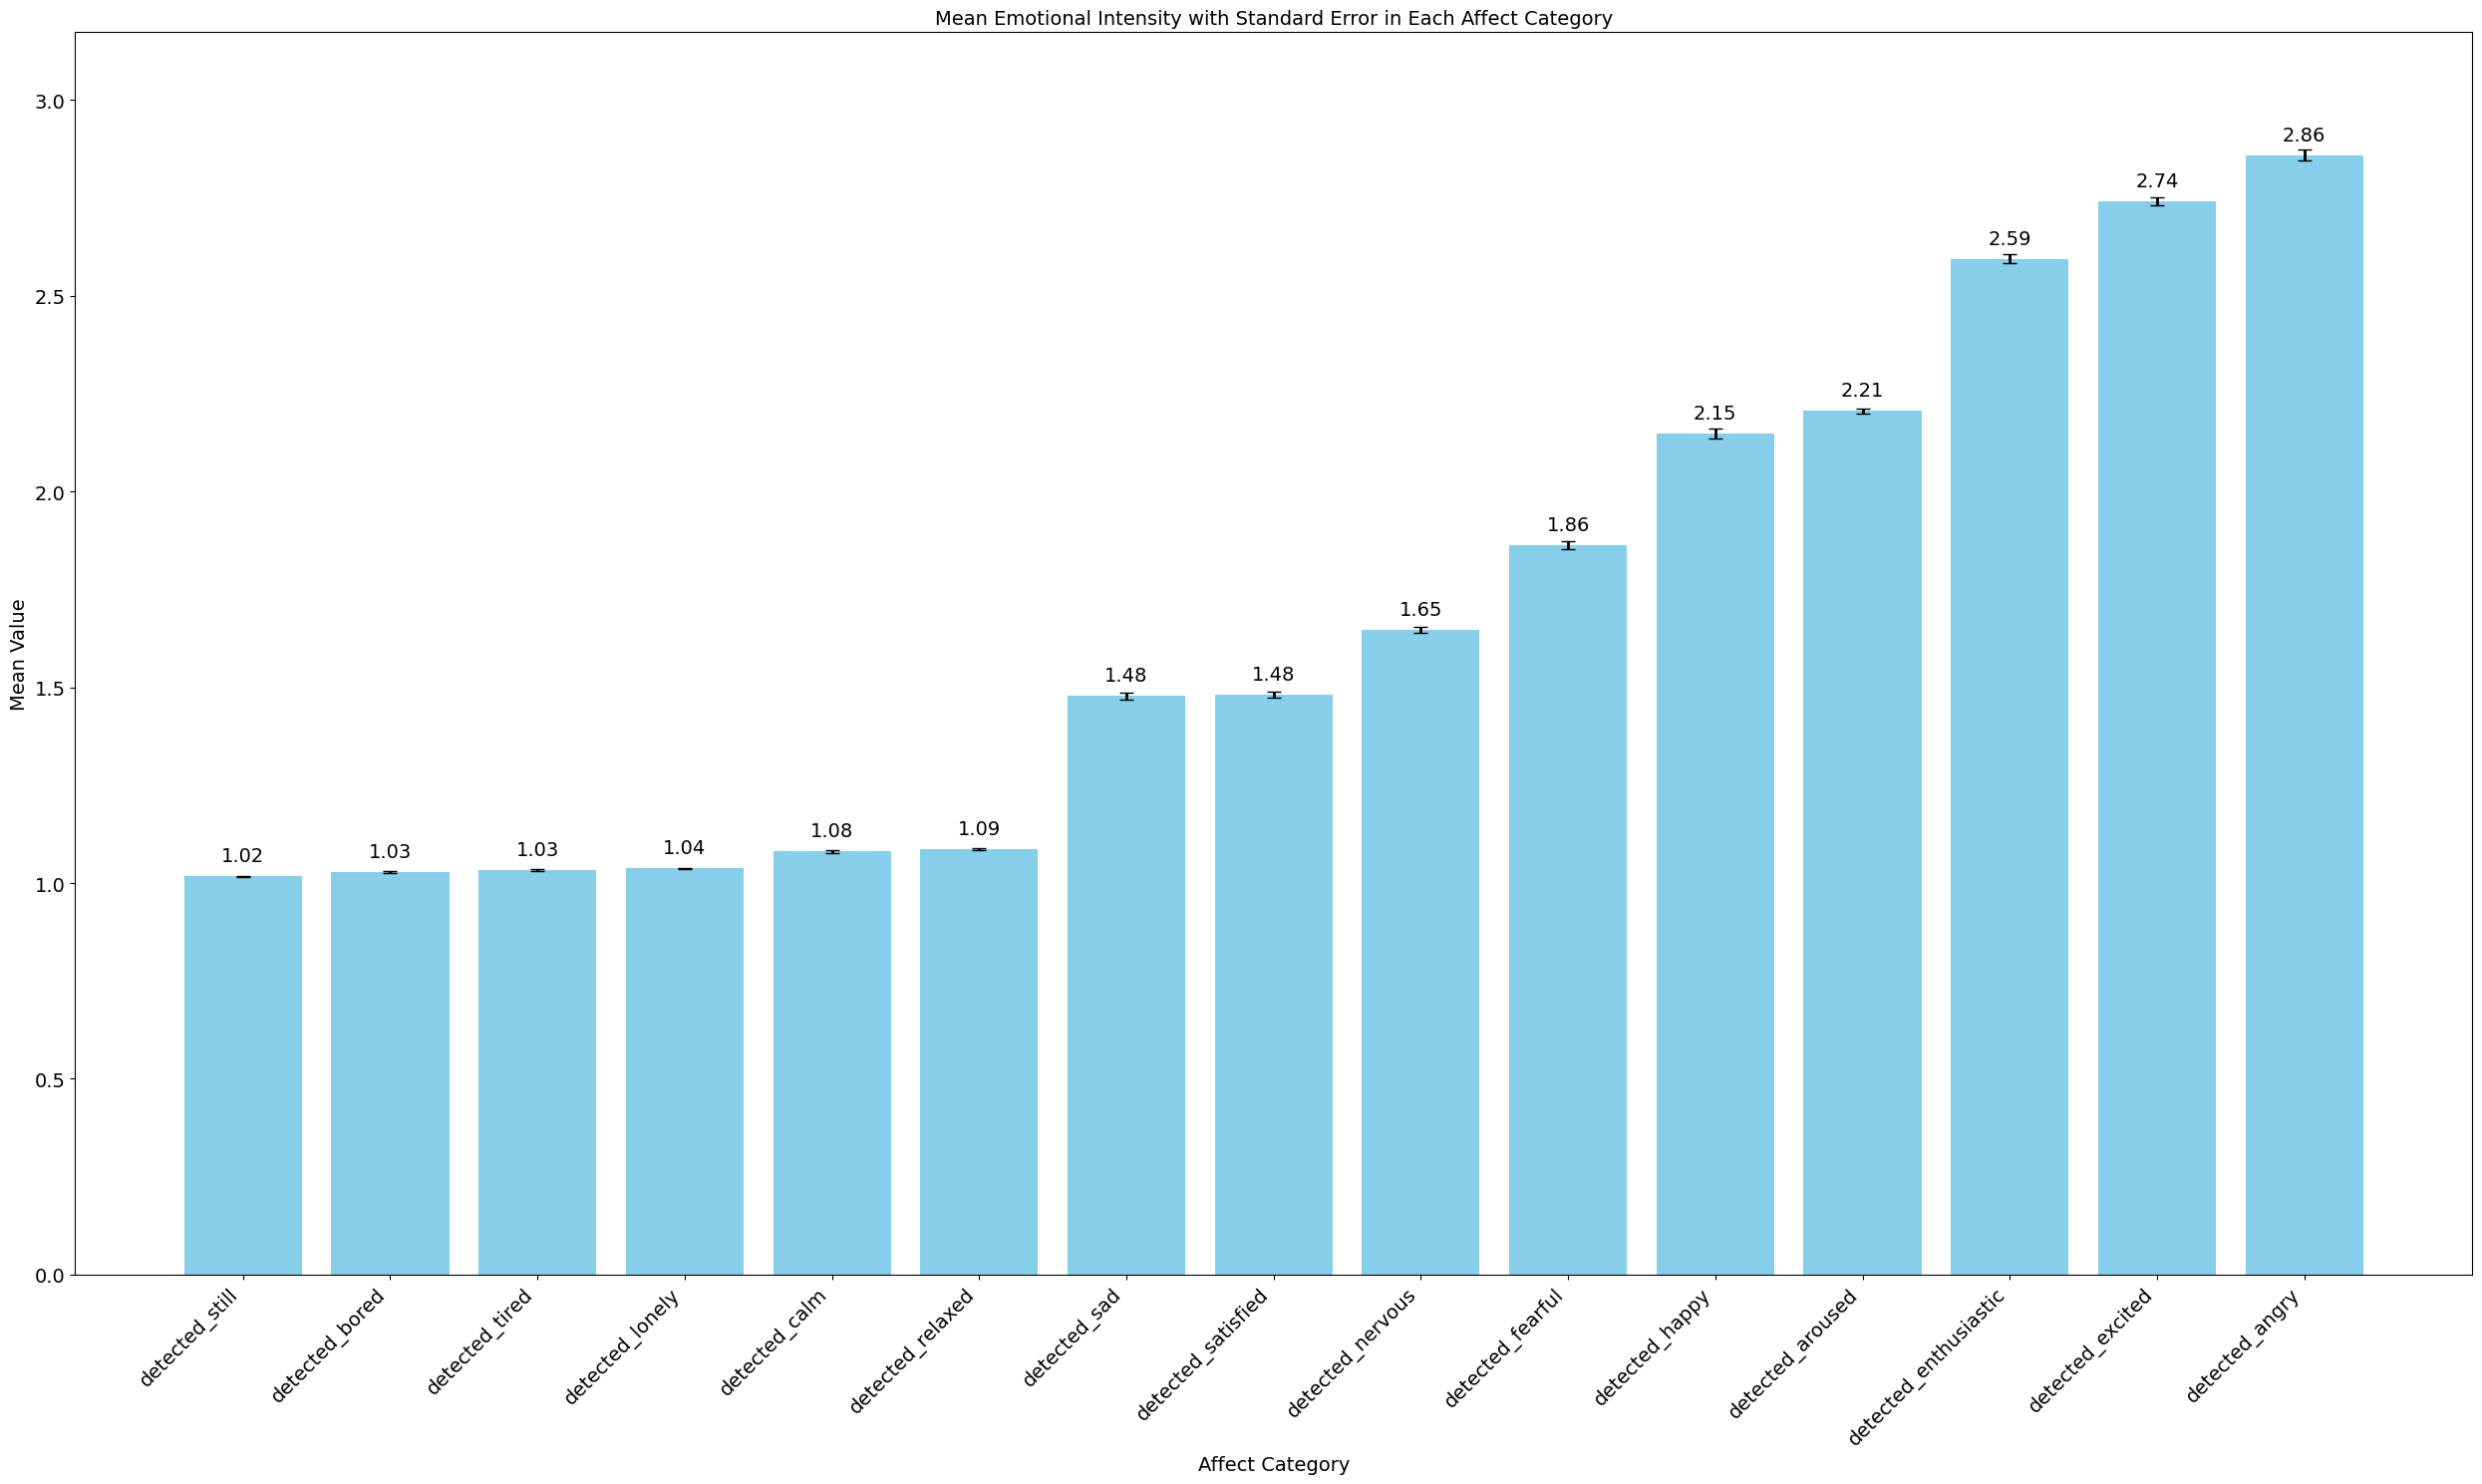

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of emotion categories
emotion_categories = [
    'detected_sad', 'detected_angry', 'detected_calm', 'detected_excited', 
    'detected_nervous', 'detected_happy', 'detected_aroused', 'detected_relaxed', 
    'detected_fearful', 'detected_enthusiastic', 'detected_still', 'detected_satisfied', 
    'detected_bored', 'detected_lonely', 'detected_tired'
]

# Calculate the mean and standard error for each emotion
emotion_means = {emotion: df[emotion].mean() for emotion in emotion_categories}
emotion_std = {emotion: df[emotion].std() for emotion in emotion_categories}
emotion_n = {emotion: df[emotion].count() for emotion in emotion_categories}  # Number of valid observations

# Calculate standard error
emotion_se = {emotion: (emotion_std[emotion] / np.sqrt(emotion_n[emotion])) if emotion_n[emotion] > 0 else 0
              for emotion in emotion_categories}

# Sort data by mean for visualization
sorted_emotion_means = dict(sorted(emotion_means.items(), key=lambda item: item[1], reverse=False))
sorted_emotion_se = {emotion: emotion_se[emotion] for emotion in sorted_emotion_means.keys()}

# Extract emotions and their computed means and errors
emotions = list(sorted_emotion_means.keys())
means = [sorted_emotion_means[emotion] for emotion in emotions]
errors = [sorted_emotion_se[emotion] for emotion in emotions]

# Plotting the data with error bars
plt.figure(figsize=(25, 15))
plt.ylim(0, max(means) * 1.1 + max(errors) * 2)  # Adjust the y-axis limit dynamically
bars = plt.bar(emotions, means, yerr=errors, capsize=5, color='skyblue', error_kw={'elinewidth': 2})

# Add the mean numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + max(errors) * 2, f"{yval:.2f}", 
             ha='center', va='bottom', fontsize=14)

# Labels and title
plt.xlabel("Affect Category", fontsize=14)
plt.ylabel("Mean Value", fontsize=14)
plt.title("Mean Emotional Intensity with Standard Error in Each Affect Category", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate the labels for better readability
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to avoid clipping of labels

plt.savefig("output_graphs/mean_emotion_intensity.png", format="png")


# Display the plot
plt.show()


In [54]:
print(len(df))

2818


In [7]:
"""
Clean up the file
"""
df = pd.read_csv("combined_output_affect.csv")

emotion_categories = [
    'Nervous', 'Sad', 'Happy', 'Calm', 'Excited', 'Aroused', 
    'Angry', 'Relaxed', 'Fearful', 'Enthusiastic', 'Still', 
    'Satisfied', 'Bored', 'Lonely', 'Tired'
]

def check_non_numeric(row):
    return any(not str(row[cat]).replace('.', '', 1).isdigit() for cat in emotion_categories if cat in row)
non_numeric_rows = df.apply(check_non_numeric, axis=1)
print(non_numeric_rows.describe())
# clean_df = df[~non_numeric_rows]

# clean_df.to_csv('cleaned_combined_output_affect.csv', index=False)

count     12142
unique        1
top       False
freq      12142
dtype: object


In [ ]:
"""
print problematic rows
"""
df = pd.read_csv('combined_output_affect.csv')
def check_non_numeric(row):
    return any(not str(val).replace('.', '', 1).isdigit() for val in row)
non_numeric_rows = df.apply(check_non_numeric, axis=1)
print(df[non_numeric_rows])

In [62]:
"""
Output a New "Flattened" CSV
"""
header = ["user_id", "tab_id", "question_id", "name", "value", "question_type", "tweet_id", "user_condition", "party", "origin", "batch_id", "batch_condition"]
header_new = ["user_id", "tab_id", "question_id", "angry", "excited", "calm", "sad", "question_type", "tweet_id", "user_condition", "party", "origin", "batch_id", "batch_condition"]

processed_tweet_ids = {}

with open('emotions.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header

    for row in reader:
        tweet_id = row[6]
        name = row[3]
        value = row[4]

        # Initialize row data if tweet_id is new
        if tweet_id not in processed_tweet_ids:
            processed_tweet_ids[tweet_id] = {
                "user_id": row[0], "tab_id": row[1], "question_id": row[2],
                "angry": None, "excited": None, "calm": None, "sad": None,
                "question_type": row[5], "tweet_id": tweet_id, 
                "user_condition": row[7], "party": row[8], "origin": row[9],
                "batch_id": row[10], "batch_condition": row[11]
            }

        # Update the corresponding emotion value
        if name == "angry":
            processed_tweet_ids[tweet_id]["angry"] = value
        elif name == "excited":
            processed_tweet_ids[tweet_id]["excited"] = value
        elif name == "calm":
            processed_tweet_ids[tweet_id]["calm"] = value
        elif name == "sad":
            processed_tweet_ids[tweet_id]["sad"] = value

# Write to the new CSV file
with open('processed_emotions.csv', 'w', newline='') as file1:
    writer1 = csv.writer(file1)
    writer1.writerow(header_new)  # Write new header

    # Write each processed row
    for data in processed_tweet_ids.values():
        new_row = [
            data["user_id"], data["tab_id"], data["question_id"], 
            data["angry"], data["excited"], data["calm"], data["sad"], 
            data["question_type"], data["tweet_id"], data["user_condition"], 
            data["party"], data["origin"], data["batch_id"], data["batch_condition"]
        ]
        writer1.writerow(new_row)

In [9]:
"""
Join processed_emotion and cleaned_combined_output_affect files based on tweet ids
"""
df1 = pd.read_csv("processed_emotions.csv")
df2 = pd.read_csv("combined_output_affect.csv")

df1['tweet_id'] = df1['tweet_id'].astype(str)
df2['id'] = df2['id'].str.replace("tweet-", "").astype(str)

merged_df = pd.merge(df1, df2, left_on="tweet_id", right_on="id", how="inner")
merged_df.describe()
merged_df.to_csv("merged_output.csv", index=False)


In [47]:
"""
Join processed_emotion and combined_output_category files based on tweet ids
"""
df1 = pd.read_csv("processed_emotions.csv")
df2 = pd.read_csv("combined_output_category.csv")
df1['tweet_id'] = df1['tweet_id'].astype(str)
df2['id'] = df2['id'].str.replace("tweet-", "").astype(str)

merged_df = pd.merge(df1, df2, left_on="tweet_id", right_on="id", how="inner")
result_df = merged_df[["tweet_id", "user_id", "user_condition", "Neutral", "Low-Arousal Negative", "High-Arousal Negative", "Low-Arousal Positive", "High-Arousal Positive", "sad", "angry", "calm", "excited"]]
result_df.to_csv("merged_output_category.csv", index=False)

In [39]:
"""
Join merged_output_category and merged_output files based on tweet ids
"""
df1 = pd.read_csv("merged_output.csv")
df2 = pd.read_csv("merged_output_category.csv")

merged_df = pd.merge(df1, df2, on="tweet_id", how="inner")

columns_to_keep = [
    "tweet_id", "user_id_x", "user_condition", "Neutral", "Low-Arousal Negative", "High-Arousal Negative",
    "Low-Arousal Positive", "High-Arousal Positive", "detected_sad", "detected_angry", "detected_calm", "detected_excited", "sad_x", "angry_x", "calm_x", "excited_x",
    
]

merged_df = merged_df[columns_to_keep].rename(columns={
    'user_id_x': 'user_id',
    'sad_x': 'sad',
    'angry_x': 'angry',
    'calm_x': 'calm',
    'excited_x': 'excited'
})

merged_df.to_csv("merged_output_all.csv", index=False)

In [11]:
print(merged_df.columns)


Index(['user_id', 'tab_id', 'question_id', 'angry', 'excited', 'calm', 'sad',
       'question_type', 'tweet_id', 'user_condition', 'party', 'origin',
       'batch_id', 'batch_condition', 'id', 'tweet', 'Nervous', 'Sad', 'Happy',
       'Calm', 'Excited', 'Aroused', 'Angry', 'Relaxed', 'Fearful',
       'Enthusiastic', 'Still', 'Satisfied', 'Bored', 'Lonely', 'Tired',
       'explanation'],
      dtype='object')


In [15]:
out = merged_df[['id','user_id', 'user_condition', 'angry', 'excited', 'calm', 'sad',  'Nervous', 'Sad', 'Happy',
       'Calm', 'Excited', 'Aroused', 'Angry', 'Relaxed', 'Fearful',
       'Enthusiastic', 'Still', 'Satisfied', 'Bored', 'Lonely', 'Tired']]


In [16]:
out = out.rename(columns={
    'Nervous': 'detected_nervous',
    'Sad': 'detected_sad',
    'Happy': 'detected_happy',
    'Calm': 'detected_calm',
    'Excited': 'detected_excited',
    'Aroused': 'detected_aroused',
    'Angry': 'detected_angry',
    'Relaxed': 'detected_relaxed',
    'Fearful': 'detected_fearful',
    'Enthusiastic': 'detected_enthusiastic',
    'Still': 'detected_still',
    'Satisfied': 'detected_satisfied',
    'Bored': 'detected_bored',
    'Lonely': 'detected_lonely',
    'Tired': 'detected_tired'
})

In [17]:
out.to_csv("joint_data_2.csv", index=False)

In [19]:
"""
Compare Correlation of Specific Emotion: Angry, Calm, Sad, Excited
"""
df = pd.read_csv('merged_output.csv')

detected_columns = ['detected_sad', 'detected_angry', 'detected_calm', 'detected_excited']
actual_columns = ['sad', 'angry', 'calm', 'excited']

print("Compare Correlation of detected emotion to reported emotion")
for detected, actual in zip(detected_columns, actual_columns):
    df_filtered = df[df[actual].notna()]
    correlation = df_filtered[actual].corr(df_filtered[detected])
    print(f"Correlation between {detected} and {actual}: {correlation}")

Compare Correlation of detected emotion to reported emotion
Correlation between detected_sad and sad: 0.05415888870476867
Correlation between detected_angry and angry: 0.10715207458551472
Correlation between detected_calm and calm: 0.011688854070352335
Correlation between detected_excited and excited: 0.0740095968352521


In [30]:
"""
Compare Correlation of Detected category to specific emotions: Angry, Calm, Sad, Excited
"""
df = pd.read_csv('merged_output_category.csv')

detected_columns = ['High-Arousal Negative', 'High-Arousal Negative', 'Low-Arousal Positive', 'High-Arousal Positive']
actual_columns = ['sad', 'angry', 'calm', 'excited']

# threshold = 50

print("Compare Correlation of Detected arousal valence category to emotions")
for detected, actual in zip(detected_columns, actual_columns):
    df_filtered = df[df[actual].notna()]
    # df_filtered['actual_binary'] = (df_filtered[actual] > threshold).astype(int)
    
    correlation = df_filtered[actual].corr(df_filtered[detected])
    print(f"Correlation between {detected} and {actual}: {correlation}")

Compare Correlation of Detected arousal valence category to emotions
Correlation between High-Arousal Negative and sad: 0.05494579289743854
Correlation between High-Arousal Negative and angry: 0.09325762118407492
Correlation between Low-Arousal Positive and calm: 0.0339867355074105
Correlation between High-Arousal Positive and excited: 0.07099580780891868


In [15]:
"""
Compare Correlation of Detected category to specific emotions: Angry, Calm, Sad, Excited
"""
df = pd.read_csv('merged_output_category_filtered.csv')

detected_columns = ['Low-Arousal Negative', 'High-Arousal Negative', 'Low-Arousal Positive', 'High-Arousal Positive']
actual_columns = ['sad', 'angry', 'calm', 'excited']

# threshold = 50

for detected, actual in zip(detected_columns, actual_columns):
    df_filtered = df[df[actual].notna()]
    # df_filtered['actual_binary'] = (df_filtered[actual] > threshold).astype(int)
    output_filename = f'filtered_{actual}.csv'
    df_filtered.to_csv(output_filename, index=False)
    correlation = df_filtered[actual].corr(df_filtered[detected])
    
    print(f"Correlation between {detected} and {actual}: {correlation}")

Correlation between Low-Arousal Negative and sad: 0.03426713014339102
Correlation between High-Arousal Negative and angry: 0.03652499573468639
Correlation between Low-Arousal Positive and calm: 0.021414790896601678
Correlation between High-Arousal Positive and excited: 0.04440267379140117


In [31]:
df = pd.read_csv('merged_output.csv')
df = df[df['user_condition'] == "I_C"]

detected_columns = ['detected_sad', 'detected_angry', 'detected_calm', 'detected_excited']
actual_columns = ['sad', 'angry', 'calm', 'excited']

# threshold = 50

for detected, actual in zip(detected_columns, actual_columns):
    df_filtered = df[df[actual].notna()]
    # df_filtered['actual_binary'] = (df_filtered[actual] > threshold).astype(int)
    output_filename = f'filtered_{actual}.csv'
    df_filtered.to_csv(output_filename, index=False)
    correlation = df_filtered[actual].corr(df_filtered[detected])
    
    print(f"Correlation between {detected} and {actual}: {correlation}")



Correlation between detected_sad and sad: 0.0057886166277234625
Correlation between detected_angry and angry: 0.09349850788322922
Correlation between detected_calm and calm: 0.01126874644672393
Correlation between detected_excited and excited: 0.060403730020284346


In [ ]:
"""
Run the subcategories. 
"""
emotions_dict = {}
with open("emotions.csv", mode="r", newline='') as emotions_file:
    emotions_reader = csv.DictReader(emotions_file)
    for row in emotions_reader:
        tweet_id = row["tweet_id"]  # Replace with actual tweet ID column name if different
        user_condition = row["user_condition"]
        emotions_dict[tweet_id] = user_condition

# Open merged_output_category.csv and filter rows based on conditions
with open("merged_output_category.csv", mode="r", newline='') as merged_file, \
     open("filtered_output.csv", mode="w", newline='') as output_file:

    merged_reader = csv.reader(merged_file)
    output_writer = csv.writer(output_file)
    
    # Write the header row to the output file
    header = next(merged_reader)
    output_writer.writerow(header)
    
    # Process each row in merged_output_category.csv
    for row in merged_reader:
        tweet_id = row[0]  # Assuming tweet_id is in the first column
        # Check if tweet_id exists in emotions_dict and meets the condition
        if tweet_id in emotions_dict and emotions_dict[tweet_id] == "I_C":
            output_writer.writerow(row)

print("Filtered rows have been written to filtered_output.csv.")


In [65]:
# sad, detected_sad
df = pd.read_csv('merged_output.csv')

# Filter rows where 'sad' column has non-None (non-NaN) values
df_filtered = df[df['angry'].notna()]

print(df_filtered)

# Convert the 'sad' column to binary values based on the threshold
threshold = 50
df_filtered['angry_binary'] = (df_filtered['angry'] > threshold).astype(int)
correlation = df_filtered['angry_binary'].corr(df_filtered['detected_angry'])

print(f"Correlation between angry and detected_angry: ", correlation)

                  tweet_id  detected_sad  detected_angry  detected_calm  \
0      1810414500534755348             0               0              0   
4      1810406619957940242             0               0              0   
5      1810418782306804072             0               1              0   
9      1810462016555126963             0               1              0   
10     1810489810076704998             0               1              0   
...                    ...           ...             ...            ...   
12271  1825746963796549644             0               1              0   
12272  1825973724715299013             0               1              0   
12280  1826590217886953644             0               1              0   
12282  1826888306262426013             0               0              0   
12283  1826786088867786994             0               1              0   

       detected_excited  sad  angry   calm  excited  
0                     0  NaN   25.0   52.0   

/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_22310/2190139402.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['angry_binary'] = (df_filtered['angry'] > threshold).astype(int)


### Calculate substracting mean of each user

In [3]:
"""
First get a mean emotion score of each user.
"""
df1 = pd.read_csv("processed_emotions.csv")

# Group by 'user_id' and calculate the mean of each emotion column
df1[['angry', 'excited', 'calm', 'sad']] = df1[['angry', 'excited', 'calm', 'sad']].fillna(0)
mean_emotions = df1.groupby('user_id')[['angry', 'excited', 'calm', 'sad']].mean()

# Rename columns to indicate these are mean values
mean_emotions = mean_emotions.rename(columns={
    'angry': 'mean_angry',
    'excited': 'mean_excited',
    'calm': 'mean_calm',
    'sad': 'mean_sad'
})

# Reset index to make 'user_id' a column again
mean_emotions = mean_emotions.reset_index()

mean_emotions.to_csv("mean_emotions_per_user.csv", index=False)

In [19]:
"""
Get a z score for each user's data.
"""
import pandas as pd

# Step 1: Read the CSV file
df1 = pd.read_csv("processed_emotions.csv")

# Step 2: Replace None with 0 in the emotion columns for calculation
df1[['angry', 'excited', 'calm', 'sad']] = df1[['angry', 'excited', 'calm', 'sad']].fillna(0)

# Step 3: Calculate the mean and standard deviation of each emotion column for each user
mean_emotions = df1.groupby('user_id')[['angry', 'excited', 'calm', 'sad']].mean()
std_emotions = df1.groupby('user_id')[['angry', 'excited', 'calm', 'sad']].std()

# Step 4: Rename columns to indicate these are mean and std values
mean_emotions = mean_emotions.rename(columns={
    'angry': 'mean_angry',
    'excited': 'mean_excited',
    'calm': 'mean_calm',
    'sad': 'mean_sad'
})
std_emotions = std_emotions.rename(columns={
    'angry': 'std_angry',
    'excited': 'std_excited',
    'calm': 'std_calm',
    'sad': 'std_sad'
})

# Step 5: Merge mean and std DataFrames on 'user_id'
user_emotions = mean_emotions.merge(std_emotions, on='user_id')

# Step 6: Reset index and save to CSV
user_emotions = user_emotions.reset_index()
user_emotions.to_csv("mean_and_std_emotions_per_user.csv", index=False)


In [12]:
"""
Join the mean emotion per user to merged_output.
"""
df1 = pd.read_csv("merged_output.csv")
df2 = pd.read_csv("mean_emotions_per_user.csv")

# merging data from df2 to df1, realocating the rows of mean_emotions based on the user id matching. 

merged_df = pd.merge(df1, df2, left_on="user_id", right_on="user_id", how="inner")
result_df = merged_df[["tweet_id", "user_id", "detected_sad", "detected_angry", "detected_calm", "detected_excited", "sad", "angry", "calm", "excited", 'mean_angry','mean_excited','mean_calm','mean_sad']]
result_df.to_csv("merged_output_with_mean.csv", index=False)

In [13]:
"""
Join the mean emotion per user to merged_output_category.
"""
df1 = pd.read_csv("merged_output_category.csv")
df2 = pd.read_csv("mean_emotions_per_user.csv")

# merging data from df2 to df1, realocating the rows of mean_emotions based on the user id matching. 

merged_df = pd.merge(df1, df2, left_on="user_id", right_on="user_id", how="inner")
result_df = merged_df[["tweet_id", "user_id", "Neutral", "Low-Arousal Negative", "High-Arousal Negative", "Low-Arousal Positive", "High-Arousal Positive", "sad", "angry", "calm", "excited", "mean_angry", "mean_excited", "mean_calm", "mean_sad"]]
result_df.to_csv("merged_output_category_with_mean.csv", index=False)

In [10]:
df = pd.read_csv('merged_output_with_mean.csv')

detected_columns = ['detected_sad', 'detected_angry', 'detected_calm', 'detected_excited']
actual_columns = ['sad', 'angry', 'calm', 'excited']
mean_columns = ['mean_sad', 'mean_angry', 'mean_calm', 'mean_excited']

for detected, actual, mean in zip(detected_columns, actual_columns, mean_columns):
    # Filter rows where actual values are not missing
    df_filtered = df[df[actual].notna()]

    # Subtract the mean for each actual value
    df_filtered[f"{actual}_adjusted"] = df_filtered[actual] - df_filtered[mean]

    # Calculate the correlation between the adjusted actual values and detected values
    correlation = df_filtered[f"{actual}_adjusted"].corr(df_filtered[detected])
    
    print(f"Correlation between adjusted {actual} and {detected}: {correlation}")


Compare Correlation of detected emotion to reported emotion (after mean adjustment)
Correlation between adjusted sad and detected_sad: 0.025284521776586875
Correlation between adjusted angry and detected_angry: 0.08774660826485414
Correlation between adjusted calm and detected_calm: 0.031632695732345374
Correlation between adjusted excited and detected_excited: 0.06185818877530859


/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_78075/4155571039.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f"{actual}_adjusted"] = df_filtered[actual] - df_filtered[mean]
/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_78075/4155571039.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f"{actual}_adjusted"] = df_filtered[actual] - df_filtered[mean]
/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_78075/4155571039.py:17: SettingWithCopyWarn

In [15]:
"""
Compare Correlation of Detected category to specific emotions: Angry, Calm, Sad, Excited
"""
df = pd.read_csv('merged_output_category_with_mean.csv')

detected_columns = ['Low-Arousal Negative', 'High-Arousal Negative', 'Low-Arousal Positive', 'High-Arousal Positive']
actual_columns = ['sad', 'angry', 'calm', 'excited']
mean_columns = ['mean_sad', 'mean_angry', 'mean_calm', 'mean_excited']

for detected, actual, mean in zip(detected_columns, actual_columns, mean_columns):
    # Filter rows where actual values are not missing
    df_filtered = df[df[actual].notna()]

    # Subtract the mean for each actual value
    df_filtered[f"{actual}_adjusted"] = df_filtered[actual] - df_filtered[mean]

    # Calculate the correlation between the adjusted actual values and detected values
    correlation = df_filtered[f"{actual}_adjusted"].corr(df_filtered[detected])
    
    print(f"Correlation between adjusted {actual} and {detected}: {correlation}")


Correlation between adjusted sad and Low-Arousal Negative: 0.021365844937717524
Correlation between adjusted angry and High-Arousal Negative: 0.07704017276417134
Correlation between adjusted calm and Low-Arousal Positive: 0.03415802270662223
Correlation between adjusted excited and High-Arousal Positive: 0.06172370824490465


/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_78075/3486744010.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f"{actual}_adjusted"] = df_filtered[actual] - df_filtered[mean]
/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_78075/3486744010.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f"{actual}_adjusted"] = df_filtered[actual] - df_filtered[mean]
/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_78075/3486744010.py:15: SettingWithCopyWarn

### More Analytics

In [5]:
import pandas as pd

# Load the dataframes
df1 = pd.read_csv('merged_output_all.csv')
df2 = pd.read_csv('combined_output_affect.csv')

# Select specific columns from df2
df2 = df2[['id', 'Nervous', 'Sad', 'Happy', 'Calm', 'Excited', 'Aroused', 'Angry', 'Relaxed', 
           'Fearful', 'Enthusiastic', 'Still', 'Satisfied', 'Bored', 'Lonely', 'Tired']]
df2 = df2.rename(columns={
    'Nervous': 'detected_nervous',
    'Sad': 'detected_sad',
    'Happy': 'detected_happy',
    'Calm': 'detected_calm',
    'Excited': 'detected_excited',
    'Aroused': 'detected_aroused',
    'Angry': 'detected_angry',
    'Relaxed': 'detected_relaxed',
    'Fearful': 'detected_fearful',
    'Enthusiastic': 'detected_enthusiastic',
    'Still': 'detected_still',
    'Satisfied': 'detected_satisfied',
    'Bored': 'detected_bored',
    'Lonely': 'detected_lonely',
    'Tired': 'detected_tired'
})
df2.columns = df2.columns.str.lower()
df2['id'] = df2['id'].str.replace('tweet-', '', regex=False)
df2['id'] = pd.to_numeric(df2['id'], errors='coerce')

df1 = df1[['tweet_id','user_id', 'user_condition', 
            'Neutral', 'Low-Arousal Negative', 'High-Arousal Negative', 'Low-Arousal Positive', 'High-Arousal Positive', 
            'sad', 'angry', 'calm', 'excited']]

df1.rename(columns={'tweet_id': 'id'}, inplace=True)
df1['id'] = pd.to_numeric(df1['id'], errors='coerce')

merged_df = pd.merge(df1, df2, on='id', how='inner')

merged_df.to_csv('futher.csv', index=False)


Merged CSV saved as 'merged_output_A111.csv'


In [29]:
# merge the gender, age, ladder
pre = pd.read_csv('pre_study.csv')
#fur = pd.read_csv('further.csv')

pre = pre[['participantId', 'Gender', 'age', 'ladder',
           'emo_enthusiastic', 'emo_happy', 'emo_still', 'emo_lonely', 
           'emo_sad', 'emo_nervous', 'emo_satisfied', 'emo_calm', 
           'emo_relaxed', 'emo_tired', 'emo_fearful', 'emo_aroused', 
           'emo_excited', 'emo_bored', 'emo_angry']]

pre.rename(columns={'participantId': 'user_id'}, inplace=True)
pre.columns = pre.columns.str.lower()

pre.head()


,user_id,gender,age,ladder,emo_enthusiastic,emo_happy,emo_still,emo_lonely,emo_sad,emo_nervous,emo_satisfied,emo_calm,emo_relaxed,emo_tired,emo_fearful,emo_aroused,emo_excited,emo_bored,emo_angry
0,iP009a45e51df9d4f5,male,41,9,_1_never,_4_most_of_the_time,_1_never,_2_small_amount,_1_never,_2_small_amount,_4_most_of_the_time,_2_small_amount,_4_most_of_the_time,_3_half_the_time,_3_half_the_time,_1_never,_4_most_of_the_time,_1_never,_2_small_amount
1,iP00d70f7a8a9e689f,male,24,4,_2_small_amount,_5_all_the_time,_3_half_the_time,_3_half_the_time,_4_most_of_the_time,_3_half_the_time,_2_small_amount,_4_most_of_the_time,_4_most_of_the_time,_1_never,_5_all_the_time,_3_half_the_time,_4_most_of_the_time,_4_most_of_the_time,_5_all_the_time
2,iP0101580a98ac0395,male,34,4,_1_never,_2_small_amount,_4_most_of_the_time,_3_half_the_time,_2_small_amount,_1_never,_4_most_of_the_time,_2_small_amount,_4_most_of_the_time,_2_small_amount,_3_half_the_time,_4_most_of_the_time,_2_small_amount,_1_never,_1_never
3,iP011d4828b4e4458b,female,34,2,_2_small_amount,_2_small_amount,_2_small_amount,_1_never,_3_half_the_time,_3_half_the_time,_3_half_the_time,_2_small_amount,_3_half_the_time,_3_half_the_time,_1_never,_1_never,_1_never,_2_small_amount,_3_half_the_time
4,iP0122f70ccf3ebf7d,female,51,4,_4_most_of_the_time,_4_most_of_the_time,_2_small_amount,_1_never,_2_small_amount,_1_never,_3_half_the_time,_4_most_of_the_time,_4_most_of_the_time,_2_small_amount,_1_never,_2_small_amount,_3_half_the_time,_2_small_amount,_2_small_amount


In [11]:
print(len(pre))

1662


In [12]:
print(len(fur))

12078


In [30]:
merged = pd.merge(out, pre, on='user_id', how='inner')

In [31]:
list(merged.columns)

['id',
 'user_id',
 'user_condition',
 'angry',
 'excited',
 'calm',
 'sad',
 'detected_nervous',
 'detected_sad',
 'detected_happy',
 'detected_calm',
 'detected_excited',
 'detected_aroused',
 'detected_angry',
 'detected_relaxed',
 'detected_fearful',
 'detected_enthusiastic',
 'detected_still',
 'detected_satisfied',
 'detected_bored',
 'detected_lonely',
 'detected_tired',
 'gender',
 'age',
 'ladder',
 'emo_enthusiastic',
 'emo_happy',
 'emo_still',
 'emo_lonely',
 'emo_sad',
 'emo_nervous',
 'emo_satisfied',
 'emo_calm',
 'emo_relaxed',
 'emo_tired',
 'emo_fearful',
 'emo_aroused',
 'emo_excited',
 'emo_bored',
 'emo_angry']

In [32]:
merged.rename(columns={'Neutral': 'NEU', 'Low-Arousal Negative': "LAN",
                    'High-Arousal Negative': 'HAN', 'Low-Arousal Positive': 'LAP', 
                    'High-Arousal Positive': 'HAP'}, inplace=True)

In [31]:
merged.rename(columns={'sad': 'survey_sad',
 'angry': 'survey_angry',
 'calm': 'survey_calm',
 'excited': 'survey_excited',}, inplace=True)
list(merged.columns)

['id',
 'user_id',
 'user_condition',
 'Neutral',
 'Low-Arousal Negative',
 'High-Arousal Negative',
 'Low-Arousal Positive',
 'High-Arousal Positive',
 'survey_sad',
 'survey_angry',
 'survey_calm',
 'survey_excited',
 'detected_nervous',
 'detected_sad',
 'detected_happy',
 'detected_calm',
 'detected_excited',
 'detected_aroused',
 'detected_angry',
 'detected_relaxed',
 'detected_fearful',
 'detected_enthusiastic',
 'detected_still',
 'detected_satisfied',
 'detected_bored',
 'detected_lonely',
 'detected_tired',
 'gender',
 'age',
 'ladder',
 'emo_enthusiastic',
 'emo_happy',
 'emo_still',
 'emo_lonely',
 'emo_sad',
 'emo_nervous',
 'emo_satisfied',
 'emo_calm',
 'emo_relaxed',
 'emo_tired',
 'emo_fearful',
 'emo_aroused',
 'emo_excited',
 'emo_bored',
 'emo_angry']

In [33]:
list(merged.columns)

['id',
 'user_id',
 'user_condition',
 'NEU',
 'LAN',
 'HAN',
 'LAP',
 'HAP',
 'survey_sad',
 'survey_angry',
 'survey_calm',
 'survey_excited',
 'detected_nervous',
 'detected_sad',
 'detected_happy',
 'detected_calm',
 'detected_excited',
 'detected_aroused',
 'detected_angry',
 'detected_relaxed',
 'detected_fearful',
 'detected_enthusiastic',
 'detected_still',
 'detected_satisfied',
 'detected_bored',
 'detected_lonely',
 'detected_tired',
 'gender',
 'age',
 'ladder',
 'emo_enthusiastic',
 'emo_happy',
 'emo_still',
 'emo_lonely',
 'emo_sad',
 'emo_nervous',
 'emo_satisfied',
 'emo_calm',
 'emo_relaxed',
 'emo_tired',
 'emo_fearful',
 'emo_aroused',
 'emo_excited',
 'emo_bored',
 'emo_angry']

In [14]:
print(len(merged))

12078


In [35]:
merged.head()

,id,user_id,user_condition,angry,excited,calm,sad,detected_nervous,detected_sad,detected_happy,...,emo_nervous,emo_satisfied,emo_calm,emo_relaxed,emo_tired,emo_fearful,emo_aroused,emo_excited,emo_bored,emo_angry
0,1810414500534755348,32FC87F1C127480BA90BCC9764065560,I_T,25.0,NaN,52.0,NaN,1,1,4,...,1,1,3,3,3,1,1,2,2,2
1,1810420678304161918,98FB48ECFC1F4805A4D3243BC96E6AC0,R_C,NaN,NaN,75.0,24.0,1,2,3,...,1,2,3,4,1,1,2,2,1,2
2,1810398884117832109,793F4EA5961D45F29E68D1C22D34C67E,I_T,NaN,35.0,NaN,3.0,1,1,3,...,2,3,3,4,2,2,2,3,2,2
3,1810480643697979546,15320287CE574BA982689DD555E81480,I_C,NaN,NaN,78.0,0.0,2,1,2,...,1,4,5,5,1,2,1,3,1,2
4,1810406619957940242,E4AA2713E85B44218945B12E27CB2643,I_T,51.0,NaN,38.0,NaN,1,1,4,...,3,2,1,1,3,2,2,2,2,3


In [36]:
merged.to_csv('merged.csv', index=False)

In [34]:
# convert the pre-emotion to 1-5 numerical
# m = pd.read_csv('merged.csv')
# m.head()

columns = ['emo_enthusiastic',
 'emo_happy',
 'emo_still',
 'emo_lonely',
 'emo_sad',
 'emo_nervous',
 'emo_satisfied',
 'emo_calm',
 'emo_relaxed',
 'emo_tired',
 'emo_fearful',
 'emo_aroused',
 'emo_excited',
 'emo_bored',
 'emo_angry']

conversion_map = {
    '_3_half_the_time': 3,
    '_1_never': 1,
    '_2_small_amount': 2,
    '_4_most_of_the_time': 4,
    '_5_all_the_time': 5
}

for column in columns:
    merged[column] = merged[column].replace(conversion_map)

merged.head()

,id,user_id,user_condition,angry,excited,calm,sad,detected_nervous,detected_sad,detected_happy,...,emo_nervous,emo_satisfied,emo_calm,emo_relaxed,emo_tired,emo_fearful,emo_aroused,emo_excited,emo_bored,emo_angry
0,1810414500534755348,32FC87F1C127480BA90BCC9764065560,I_T,25.0,NaN,52.0,NaN,1,1,4,...,1,1,3,3,3,1,1,2,2,2
1,1810420678304161918,98FB48ECFC1F4805A4D3243BC96E6AC0,R_C,NaN,NaN,75.0,24.0,1,2,3,...,1,2,3,4,1,1,2,2,1,2
2,1810398884117832109,793F4EA5961D45F29E68D1C22D34C67E,I_T,NaN,35.0,NaN,3.0,1,1,3,...,2,3,3,4,2,2,2,3,2,2
3,1810480643697979546,15320287CE574BA982689DD555E81480,I_C,NaN,NaN,78.0,0.0,2,1,2,...,1,4,5,5,1,2,1,3,1,2
4,1810406619957940242,E4AA2713E85B44218945B12E27CB2643,I_T,51.0,NaN,38.0,NaN,1,1,4,...,3,2,1,1,3,2,2,2,2,3


In [40]:
m.to_csv('merged11.csv', index=False)

In [1]:
con = pd.read_csv('further.csv')


NameError: name 'pd' is not defined

In [93]:
con.rename(columns={'Neutral': 'NEU', 'Low-Arousal Negative': "LAN",
                    'High-Arousal Negative': 'HAN', 'Low-Arousal Positive': 'LAP', 
                    'High-Arousal Positive': 'HAP'}, inplace=True)
con.head()

,id,user_id,user_condition,NEU,LAN,HAN,LAP,HAP,detected_sad,detected_angry,...,happy,aroused,relaxed,fearful,enthusiastic,still,satisfied,bored,lonely,tired
0,1810414500534755348,32FC87F1C127480BA90BCC9764065560,I_T,1,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
1,1810420678304161918,98FB48ECFC1F4805A4D3243BC96E6AC0,R_C,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1810398884117832109,793F4EA5961D45F29E68D1C22D34C67E,I_T,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
3,1810480643697979546,15320287CE574BA982689DD555E81480,I_C,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1810406619957940242,E4AA2713E85B44218945B12E27CB2643,I_T,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [94]:
import pandas as pd

# Assuming df is your DataFrame
df = pd.DataFrame(columns=['nervous', 
                           'happy', 'aroused', 'relaxed', 'fearful', 
                           'enthusiastic', 'still', 'satisfied', 
                           'bored', 'lonely', 'tired'])

# Rename columns to '{emotion}'
con.rename(columns={col: f"detected_{col}" for col in df.columns}, inplace=True)

# Check the updated columns
print(con.columns)

Index(['id', 'user_id', 'user_condition', 'NEU', 'LAN', 'HAN', 'LAP', 'HAP',
       'detected_sad', 'detected_angry', 'detected_calm', 'detected_excited',
       'sad', 'angry', 'calm', 'excited', 'detected_nervous', 'detected_happy',
       'detected_aroused', 'detected_relaxed', 'detected_fearful',
       'detected_enthusiastic', 'detected_still', 'detected_satisfied',
       'detected_bored', 'detected_lonely', 'detected_tired'],
      dtype='object')


In [95]:
list(con.columns)

['id',
 'user_id',
 'user_condition',
 'NEU',
 'LAN',
 'HAN',
 'LAP',
 'HAP',
 'detected_sad',
 'detected_angry',
 'detected_calm',
 'detected_excited',
 'sad',
 'angry',
 'calm',
 'excited',
 'detected_nervous',
 'detected_happy',
 'detected_aroused',
 'detected_relaxed',
 'detected_fearful',
 'detected_enthusiastic',
 'detected_still',
 'detected_satisfied',
 'detected_bored',
 'detected_lonely',
 'detected_tired']

In [98]:
filter = con[['detected_sad',
 'detected_angry',
 'detected_calm',
 'detected_excited',
 'detected_nervous',
 'detected_happy',
 'detected_aroused',
 'detected_relaxed',
 'detected_fearful',
 'detected_enthusiastic',
 'detected_still',
 'detected_satisfied',
 'detected_bored',
 'detected_lonely',
 'detected_tired']]
filter.head()

,detected_sad,detected_angry,detected_calm,detected_excited,detected_nervous,detected_happy,detected_aroused,detected_relaxed,detected_fearful,detected_enthusiastic,detected_still,detected_satisfied,detected_bored,detected_lonely,detected_tired
0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0


In [78]:
non_numeric_columns = con.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

Index(['user_id', 'user_condition'], dtype='object')


In [101]:
cormat = filter.corr()
round(cormat,2)

,detected_sad,detected_angry,detected_calm,detected_excited,detected_nervous,detected_happy,detected_aroused,detected_relaxed,detected_fearful,detected_enthusiastic,detected_still,detected_satisfied,detected_bored,detected_lonely,detected_tired
detected_sad,1.00,0.18,-0.07,-0.37,0.20,-0.29,-0.06,-0.07,0.27,-0.34,-0.01,-0.19,-0.03,0.10,0.04
detected_angry,0.18,1.00,-0.14,-0.54,0.07,-0.57,-0.03,-0.14,0.16,-0.63,-0.02,-0.38,-0.05,-0.05,-0.04
detected_calm,-0.07,-0.14,1.00,0.02,-0.06,0.15,-0.01,0.83,-0.06,0.08,0.10,0.24,-0.00,-0.00,0.02
detected_excited,-0.37,-0.54,0.02,1.00,-0.24,0.63,0.15,0.03,-0.28,0.82,-0.01,0.41,-0.05,-0.05,-0.02
detected_nervous,0.20,0.07,-0.06,-0.24,1.00,-0.24,-0.04,-0.05,0.74,-0.26,-0.01,-0.16,-0.04,0.02,-0.01
detected_happy,-0.29,-0.57,0.15,0.63,-0.24,1.00,-0.02,0.18,-0.27,0.79,0.00,0.63,-0.03,-0.04,-0.01
detected_aroused,-0.06,-0.03,-0.01,0.15,-0.04,-0.02,1.00,-0.01,-0.03,0.12,-0.00,-0.03,-0.01,-0.00,-0.01
detected_relaxed,-0.07,-0.14,0.83,0.03,-0.05,0.18,-0.01,1.00,-0.06,0.10,0.08,0.27,-0.00,-0.00,0.05
detected_fearful,0.27,0.16,-0.06,-0.28,0.74,-0.27,-0.03,-0.06,1.00,-0.30,-0.01,-0.18,-0.04,0.01,-0.02
detected_enthusiastic,-0.34,-0.63,0.08,0.82,-0.26,0.79,0.12,0.10,-0.30,1.00,-0.01,0.52,-0.05,-0.04,-0.02


<Axes: >

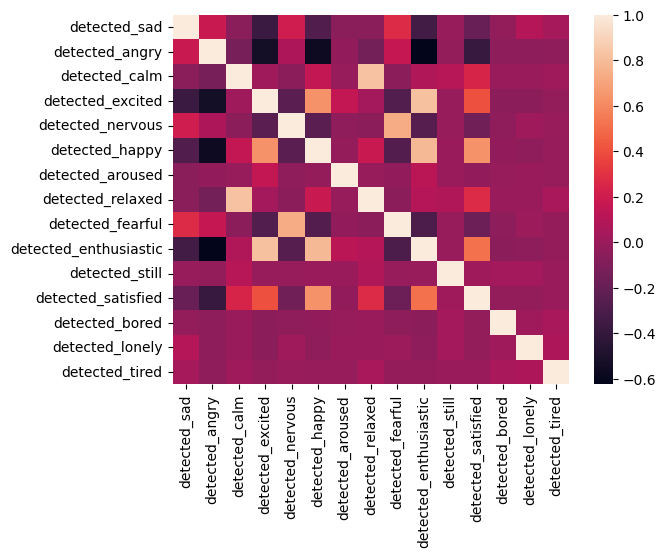

In [102]:
sns.heatmap(cormat)

In [35]:
con_fil = con[con["angry"].notna()]

In [36]:
con_fil.head()

,tweet_id,user_id,NEU,LAN,HAN,LAP,HAP,detected_sad,detected_angry,detected_calm,detected_excited,sad,angry,calm,excited
0,1810414500534755348,32FC87F1C127480BA90BCC9764065560,1,0,0,0,0,0,0,0,1,NaN,25.0,52.0,NaN
4,1810406619957940242,E4AA2713E85B44218945B12E27CB2643,0,0,0,0,1,0,0,0,1,NaN,51.0,38.0,NaN
5,1810418782306804072,6D17957AE4F94780B4EB52E11DC26BE0,0,0,1,0,0,1,1,0,0,NaN,1.0,NaN,25.0
9,1810462016555126963,86F97F7BCECD4968B1B69BB5B0394E5E,0,0,1,0,0,0,1,0,0,NaN,0.0,100.0,NaN
10,1810489810076704998,86F97F7BCECD4968B1B69BB5B0394E5E,0,0,1,0,0,0,1,0,0,NaN,0.0,NaN,0.0


### Collapse detected_emo to arousal valence

In [ ]:
"""
1. High Arousal / Positive Valence:

    Happy
    Excited
    Enthusiastic

2. High Arousal / Negative Valence:

    Angry
    Fearful
    Nervous

3. Low Arousal / Positive Valence:

    Calm
    Relaxed
    Satisfied
    Still

4. Low Arousal / Negative Valence:

    Sad
    Bored
    Lonely
    Tired
"""

In [24]:
import pandas as pd

# Step 1: Read the CSV file
df = pd.read_csv('joint_data.csv')

# add four colums for the dataset: LAN,HAN,LAP,HAP,
# all with initial as 0

# Step 2: Define a function to categorize emotions and update NEU, LAN, HAN, LAP
def update_emotions(row):
    # Reset the categories
    row['NEU'] = 0
    row['LAN'] = 0
    row['HAN'] = 0
    row['LAP'] = 0

    # High Arousal / Positive Valence -> HAP (Happy, Excited, Enthusiastic)
    if row['detected_happy'] == 1 or row['detected_excited'] == 1 or row['detected_enthusiastic'] == 1:
        row['HAP'] = 1
    
    # High Arousal / Negative Valence -> HAN (Angry, Fearful, Nervous)
    if row['detected_angry'] == 1 or row['detected_fearful'] == 1 or row['detected_nervous'] == 1:
        row['HAN'] = 1
    
    # Low Arousal / Positive Valence -> LAP (Calm, Relaxed, Satisfied, Still)
    if row['detected_calm'] == 1 or row['detected_relaxed'] == 1 or row['detected_satisfied'] == 1 or row['detected_still'] == 1:
        row['LAP'] = 1
    
    # Low Arousal / Negative Valence -> LAN (Sad, Bored, Lonely, Tired)
    if row['detected_sad'] == 1 or row['detected_bored'] == 1 or row['detected_lonely'] == 1 or row['detected_tired'] == 1:
        row['LAN'] = 1

    return row

# Step 3: Apply the function to the dataframe
df = df.apply(update_emotions, axis=1)

# Step 4: Output the updated dataframe to a new CSV file
df.to_csv('joint_data_arousalValence_from_emotion.csv', index=False)

# Print a message indicating completion
print("CSV file has been updated and saved as 'updated_file.csv'.")

CSV file has been updated and saved as 'updated_file.csv'.


In [1]:
# Map detected emotions to arousal/valence categories and save updated CSV
import pandas as pd

# Step 1: Read the CSV file
df = pd.read_csv('merged.csv')

# add four colums for the dataset: LAN,HAN,LAP,HAP,
df['LAN'] = 0
df['HAN'] = 0
df['LAP'] = 0
df['HAP'] = 0

# Step 2: Define a function to categorize emotions and update NEU, LAN, HAN, LAP
def update_emotions(row):

    # High Arousal / Positive Valence -> HAP (Happy, Excited, Enthusiastic)
    if row['detected_happy'] > 1 or row['detected_excited'] > 1 or row['detected_enthusiastic'] > 1:
        row['HAP'] = 1
    
    # High Arousal / Negative Valence -> HAN (Angry, Fearful, Nervous)
    if row['detected_angry'] > 1 or row['detected_fearful'] > 1 or row['detected_nervous'] > 1:
        row['HAN'] = 1
    
    # Low Arousal / Positive Valence -> LAP (Calm, Relaxed, Satisfied, Still)
    if row['detected_calm'] > 1 or row['detected_relaxed'] > 1 or row['detected_satisfied'] > 1 or row['detected_still'] > 1:
        row['LAP'] = 1
    
    # Low Arousal / Negative Valence -> LAN (Sad, Bored, Lonely, Tired)
    if row['detected_sad'] > 1 or row['detected_bored'] > 1 or row['detected_lonely'] > 1 or row['detected_tired'] > 1:
        row['LAN'] = 1

    return row

# Step 3: Apply the function to the dataframe
df = df.apply(update_emotions, axis=1)

# Step 4: Output the updated dataframe to a new CSV file
df.to_csv('merged1.csv', index=False)

# Print a message indicating completion
print("CSV file has been updated and saved as 'updated_file.csv'.")

CSV file has been updated and saved as 'updated_file.csv'.


### Do an average of a yes-sad and no-sad ‘s user survey_emotion_response

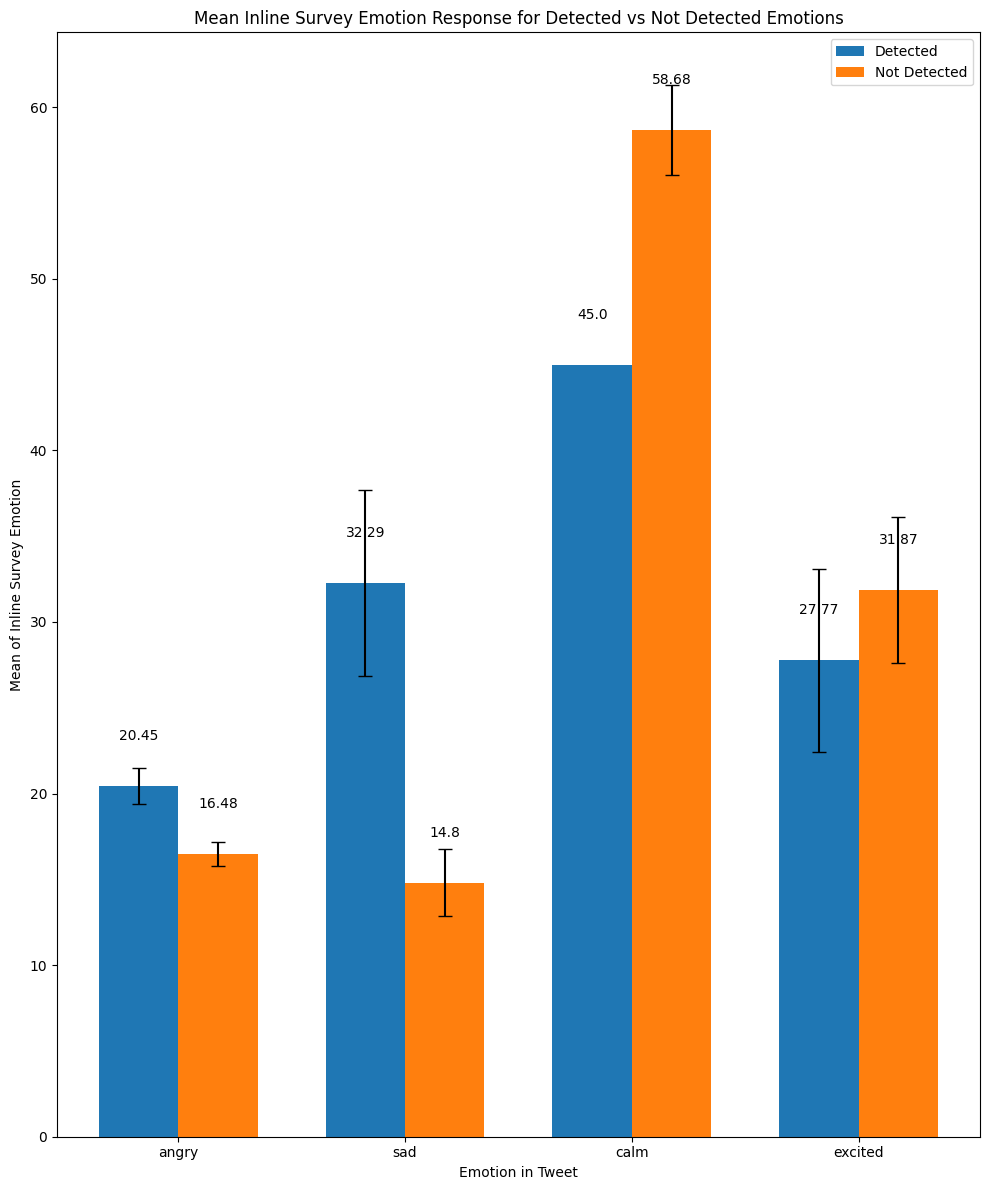

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # For the sqrt function to compute SEM

# Step 1: Load the data
df = pd.read_csv('joint_data.csv')
df = df[df['user_condition'] == 'I_C']

# Step 2: Prepare for storing results
results = []

# Step 3: Loop over each emotion and process the data
for emotion in ['angry', 'sad', 'calm', 'excited']:
    # Drop rows with NaN values in the specific inline survey column
    df = df.dropna(subset=[f'inline_survey_{emotion}'])

    # Separate the data based on whether the emotion was detected or not
    emotion_detected = df[df[f'detected_{emotion}'] == 1]
    emotion_not = df[df[f'detected_{emotion}'] == 0]

    # Calculate mean and standard deviation for both cases (detected and not detected)
    mean_yes = emotion_detected[f'inline_survey_{emotion}'].mean()
    std_yes = emotion_detected[f'inline_survey_{emotion}'].std()
    sem_yes = std_yes / np.sqrt(len(emotion_detected))  # SEM for detected

    mean_no = emotion_not[f'inline_survey_{emotion}'].mean()
    std_no = emotion_not[f'inline_survey_{emotion}'].std()
    sem_no = std_no / np.sqrt(len(emotion_not))  # SEM for not detected

    # Store the results for plotting
    results.append({
        'emotion': emotion,
        'mean_yes': mean_yes,
        'sem_yes': sem_yes,
        'mean_no': mean_no,
        'sem_no': sem_no
    })

# Step 4: Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Step 5: Plot the data
fig, ax = plt.subplots(figsize=(10, 12))

# Plotting mean with error bars for both detected and not detected using SEM
bar_width = 0.35
index = range(len(results_df))

# Plot for detected emotions (yes)
bars_yes = ax.bar(index, results_df['mean_yes'], bar_width, yerr=results_df['sem_yes'], label='Detected', capsize=5)

# Plot for not detected emotions (no)
bars_no = ax.bar([i + bar_width for i in index], results_df['mean_no'], bar_width, yerr=results_df['sem_no'], label='Not Detected', capsize=5)

# Adding labels and title
ax.set_xlabel('Emotion in Tweet')
ax.set_ylabel('Mean of Inline Survey Emotion')
ax.set_title('Mean Inline Survey Emotion Response for Detected vs Not Detected Emotions')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(results_df['emotion'])
ax.legend()

# Set the y-axis to start from 0 (remove space between the x-axis and y-axis)
ax.set_ylim(bottom=0)  # This ensures the y-axis starts from 0

# Step 6: Add mean values on top of each bar with more space above
# Annotate the bars for 'Detected' group
for bar in bars_yes:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 2.5, round(yval, 2), ha='center', va='bottom', fontsize=10)

# Annotate the bars for 'Not Detected' group
for bar in bars_no:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 2.5, round(yval, 2), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
#plt.savefig('emotion_analysis.png', format='png')
plt.show()


In [42]:
print(results)

[{'emotion': 'angry', 'mean_yes': 20.446153846153845, 'sem_yes': 1.055525476281525, 'mean_no': 16.484422110552764, 'sem_no': 0.6793119880791354}, {'emotion': 'sad', 'mean_yes': 32.285714285714285, 'sem_yes': 5.419896995950386, 'mean_no': 14.8, 'sem_no': 1.9535822896919357}, {'emotion': 'calm', 'mean_yes': 45.0, 'sem_yes': nan, 'mean_no': 58.677083333333336, 'sem_no': 2.619867362706081}, {'emotion': 'excited', 'mean_yes': 27.76923076923077, 'sem_yes': 5.321164618709732, 'mean_no': 31.869565217391305, 'sem_no': 4.248399379823558}]


In [53]:
# Check the sample sizes
len_yes = len(df[df[f'detected_calm'] == 1])
len_no = len(df[df[f'detected_calm'] == 0])

# Check the standard deviation
std_yes = df[df[f'detected_calm'] == 1][f'inline_survey_calm'].std()
std_no = df[df[f'detected_calm'] == 0][f'inline_survey_calm'].std()

print(f"Calm Detected - Length: {len_yes}, Std Dev: {std_yes}")
print(f"Calm Not Detected - Length: {len_no}, Std Dev: {std_no}")


Calm Detected - Length: 1, Std Dev: nan
Calm Not Detected - Length: 71, Std Dev: 25.294936307824564


In [54]:
# Check the sample sizes
len_yes = len(df[df[f'detected_excited'] == 1])
len_no = len(df[df[f'detected_excited'] == 0])

# Check the standard deviation
std_yes = df[df[f'detected_excited'] == 1][f'inline_survey_excited'].std()
std_no = df[df[f'detected_excited'] == 0][f'inline_survey_excited'].std()

print(f"Excited Detected - Length: {len_yes}, Std Dev: {std_yes}")
print(f"Excited Not Detected - Length: {len_no}, Std Dev: {std_no}")


Excited Detected - Length: 26, Std Dev: 27.132722225840432
Excited Not Detected - Length: 46, Std Dev: 28.814046494068112


In [55]:
# Check the sample sizes
len_yes = len(df[df[f'detected_sad'] == 1])
len_no = len(df[df[f'detected_sad'] == 0])

# Check the standard deviation
std_yes = df[df[f'detected_sad'] == 1][f'inline_survey_sad'].std()
std_no = df[df[f'detected_sad'] == 0][f'inline_survey_sad'].std()

print(f"Sad Detected - Length: {len_yes}, Std Dev: {std_yes}")
print(f"Sad Not Detected - Length: {len_no}, Std Dev: {std_no}")


Sad Detected - Length: 16, Std Dev: 28.023799409311604
Sad Not Detected - Length: 56, Std Dev: 20.560261444090408


In [56]:
# Check the sample sizes
len_yes = len(df[df[f'detected_angry'] == 1])
len_no = len(df[df[f'detected_angry'] == 0])

# Check the standard deviation
std_yes = df[df[f'detected_angry'] == 1][f'inline_survey_angry'].std()
std_no = df[df[f'detected_angry'] == 0][f'inline_survey_angry'].std()

print(f"Angry Detected - Length: {len_yes}, Std Dev: {std_yes}")
print(f"Angry Not Detected - Length: {len_no}, Std Dev: {std_no}")


Angry Detected - Length: 37, Std Dev: 21.26392848592787
Angry Not Detected - Length: 35, Std Dev: 13.822828517900891


count    4768.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: detected_sad, dtype: float64

In [14]:
yes_sad['inline_survey_sad'].describe()

count    1566.000000
mean       22.268199
std        25.633412
min         0.000000
25%         2.000000
50%        11.000000
75%        30.000000
max       100.000000
Name: inline_survey_sad, dtype: float64

In [15]:
no_sad['inline_survey_sad'].describe()

count    4768.000000
mean       19.215394
std        23.826279
min         0.000000
25%         2.000000
50%         8.000000
75%        25.000000
max       100.000000
Name: inline_survey_sad, dtype: float64

### Rerun w/ updated prompt

In [65]:
"""
Prompt Version 5
"""
def gpt_detect_emotion(tweet_text):
  """
  Call gpt to determine which emotion type it has. 
  """
  schema = {
    "Nervous": "<int 1-5>",
    "Sad": "<int 1-5>",
    "Happy": "<int 1-5>",
    "Calm": "<int 1-5>",
    "Excited": "<int 1-5>",
    "Aroused": "<int 1-5>",
    "Angry": "<int 1-5>",
    "Relaxed": "<int 1-5>",
    "Fearful": "<int 1-5>",
    "Enthusiastic": "<int 1-5>",
    "Still": "<int 1-5>",
    "Satisfied": "<int 1-5>",
    "Bored": "<int 1-5>",
    "Lonely": "<int 1-5>",
    "Tired": "<int 1-5>"
    "explanation": {"type": "string", "description": "This tweet would make the user feel ... because..."}
  }

  prompt = f""" 

    Definitions of emotions:

    Nervous: a state of restless tension and emotionality characterized by trembling, feelings of apprehensiveness, or other signs of anxiety or fear.

    Sad: the response to the loss of an object or person to which you are very attached. The prototypical experience is the death of a loved child, parent, or spouse. In sadness there is resignation, but it can turn into anguish in which there is agitation and protest over the loss and then return to sadness again.

    Happy: feelings that are enjoyed, that are sought by the person. There are a number of quite different enjoyable emotions, each triggered by a different event, involving a different signal and likely behavior. The evidence is not as strong for all of these as it is for the emotions listed above.

    Calm: free from agitation or disturbance; quiet, still, tranquil, serene. 

    Excited: a very high-intensity response to novelty and challenge, often found when there is some risk. This emotion often merges with another emotion.

    Aroused: a state of excitement or energy expenditure linked to an emotion. Usually, arousal is closely related to a person’s appraisal of the significance of an event or to the physical intensity of a stimulus. Arousal can either facilitate or debilitate performance.

    Angry: the response to interference with our pursuit of a goal we care about. Anger can also be triggered by someone attempting to harm us (physically or psychologically) or someone we care about. In addition to removing the obstacle Ekman & Cordaro Calling Emotions Basic 365 or stopping the harm, anger often involves the wish to hurt the target.

    Relaxed: abatement of intensity, vigor, energy, or tension, resulting in calmness of mind, body, or both.

    Fearful: the response to the threat of harm, physical or psycho- logical. Fear activates impulses to freeze or flee. Often fear triggers anger.

    Enthusiastic: a feeling of excitement or passion for an activity, cause, or object.

    Still: quit, calm, motionless; stationary, remaining in the same position or attitude. 

    Satisfied: to be satisfied means to have a feeling of contentment or fulfillment.

    Bored: a state of weariness or ennui resulting from a lack of engagement with stimuli in the environment. It is generally considered to be one of the least desirable conditions of daily life and is often identified by individuals as a cause of feeling depressed. It can be seen as the opposite of interest and surprise.
    
    Lonely: affective and cognitive discomfort or uneasiness from being or perceiving oneself to be alone or otherwise solitary. Psychological theory and research offer multiple perspectives: Social psychology emphasizes the emotional distress that results when inherent needs for intimacy and companionship are not met; cognitive psychology emphasizes the unpleasant and unsettling experience that results from a perceived discrepancy (i.e., deficiency in quantity or quality) between an individual’s desired and actual social relationships.

    Tired: to become weak or exhausted from exertion; to have one’s strength reduced or worn out by toil or labour; to become fatigued.

    —---

    As an expert annotator specializing in emotions in social media content, your job is to predict what emotions and feelings the input tweet would make a user feel. 

    Given the definitions of emotions above, evaluate if the input tweet would make the user feel the following emotions: Nervous, Sad, Happy, Calm, Excited, Aroused, Angry, Relaxed, Fearful, Enthusiastic, Still, Satisfied, Bored, Lonely, Tired.

    Rate the intensity of each emotion with the following categories:
        1: Not at all — the tweet would not evoke this emotion in the user.
        2: Slightly — the tweet would evoke this emotion only slightly.
        3: Moderately — the tweet would evoke this emotion to a moderate degree.
        4: Strongly — the tweet would evoke this emotion strongly.
        5: Extremely — the tweet would evoke this emotion very strongly.

    If the tweet would make the user feel that emotion, assign a 2 - 5 to the emotion category depending on the intensity; if the tweet would not make the user feel such emotion, assign a 1. 

    Also, provide a brief explanation for each of your answers that is not 1. 

    —--
    Input tweet: {tweet_text} 
    Output format: JSON object matching this structure: {json.dumps(schema, indent=2)} 

    —--

    Example input: I'm passionate about indie app development because I've been able to take months off at a time for my health and have no impact on my income 🩷 

    Example output: {{ "Nervous": 1, "Sad": 1, "Happy": 5, "Calm": 1, "Excited": 4, "Aroused": 2, "Angry": 1, "Relaxed": 1, "Fearful": 1, "Enthusiastic": 3, "Still": 1, "Satisfied": 1, "Bored": 1, "Lonely": 1, "Tired": 1, "explanation": "The tweet is likely to make a user feel extremely happy due to the use of the word “passionate” and the heart emoji 🩷. Although the tweet conveys an enthusiastic tone, it would probably make the user feel moderately enthusiastic, as they might not be interested in app development or fully empathetic toward the author of the tweet. " }} 
  
  """
  response = client.chat.completions.create(
    model="gpt-4o",
    response_format={"type":"json_object"},
    messages=[{"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
              {"role": "user", "content": prompt}],
    max_tokens=300, 
    temperature=1,
  )
  data = json.loads(response.choices[0].message.content)
  print("Detected Emotion Type: ", data)
  return data

In [67]:

gpt_header = [
    "tweet",
    "Nervous",
    "Sad",
    "Happy",
    "Calm",
    "Excited",
    "Aroused",
    "Angry",
    "Relaxed",
    "Fearful",
    "Enthusiastic",
    "Still",
    "Satisfied",
    "Bored",
    "Lonely",
    "Tired",
    "explanation"
]
with open('./gpt_tweets_emotions.csv', 'w', newline='') as file1:
    
    writer1 = csv.writer(file1)
    writer1.writerow(gpt_header)

    with open('./annotated_tweets_emotions_nov3.csv', 'r') as original_file:
        reader = csv.reader(original_file)
        next(reader)  
        
        i = 0
        for row in reader:
            tweet = row[0]
            gpt_result = gpt_detect_emotion(tweet)
            
            gpt_row = [
                tweet,
                gpt_result["Nervous"],
                gpt_result["Sad"],
                gpt_result["Happy"],
                gpt_result["Calm"],
                gpt_result["Excited"],
                gpt_result["Aroused"],
                gpt_result["Angry"],
                gpt_result["Relaxed"],
                gpt_result["Fearful"],
                gpt_result["Enthusiastic"],
                gpt_result["Still"],
                gpt_result["Satisfied"],
                gpt_result["Bored"],
                gpt_result["Lonely"],
                gpt_result["Tired"],
                gpt_result["explanation"]
            ]

            
            writer1.writerow(gpt_row)
            
            print("Tweet:", tweet)
            print("GPT row:", gpt_row[1:7])
            print("Done with row " + str(i) + " !!")
            print("-" * 20)
            
            # Increment counter
            i += 1
            if i == 5: break

Detected Emotion Type:  {'Nervous': 1, 'Sad': 2, 'Happy': 1, 'Calm': 1, 'Excited': 1, 'Aroused': 1, 'Angry': 1, 'Relaxed': 1, 'Fearful': 1, 'Enthusiastic': 1, 'Still': 1, 'Satisfied': 1, 'Bored': 1, 'Lonely': 1, 'Tired': 1, 'explanation': "The tweet would make a user feel slightly sad because it discusses the potential cancellation of an event due to low ticket sales, which can be seen as a disappointment. The use of 'lol' and the reference to calling Trump adds a sense of sarcasm or humor to the situation, which prevents stronger negative emotions from manifesting."}
Tweet: Call Trump to help lol
Quoting: Sexyy Red’s Upcoming Tour Is Reportedly On The Verge of Being Cancelled. Only 37.11% of the 85,217 Tickets Have Sold.

(via @touringdata) https://t.co/QTFqKYb4yi
GPT row: [1, 2, 1, 1, 1, 1]
Done with row 0 !!
--------------------
Detected Emotion Type:  {'Nervous': 3, 'Sad': 1, 'Happy': 1, 'Calm': 1, 'Excited': 2, 'Aroused': 2, 'Angry': 3, 'Relaxed': 1, 'Fearful': 2, 'Enthusiastic': 

In [73]:
from langdetect import detect, LangDetectException
import pandas as pd

# Load the CSV file
file_path = 'past_trials/run_server_round1/input_tweet_splits/split_3.csv'
df = pd.read_csv(file_path)

# Initialize a list to store rows with non-English tweets
non_eng_rows = []

# Loop through each row in the dataframe and check if the tweet is non-English
for index, row in df.iterrows():
    tweet = row['tweet']
    try:
        if detect(tweet) != 'en':
            non_eng_rows.append(index)  # Store the index of the non-English tweet
            print(row)  # Print out the row with the non-English tweet
    except LangDetectException:
        print(f"Error detecting language for tweet: {tweet}")  # Handle any errors in language detection

# Create a dataframe for non-English tweets
df_non_english = df.loc[non_eng_rows]

# Drop rows that have non-English tweets from the original dataframe
df_cleaned = df.drop(non_eng_rows)

# Output the number of non-English tweets removed
print(f"Total Number of non-English tweets removed: {len(non_eng_rows)}")

# Save the cleaned dataframe back to a CSV file
df_cleaned.to_csv('split_3_cleaned.csv', index=False)

# Save the non-English tweets into a separate CSV file
df_non_english.to_csv('split_3_non_english.csv', index=False)


tweet_id                            tweet-1816647649921266132
tweet       No se pierdan “EL NIVEL” de esta encuesta. \nN...
Name: 31, dtype: object
tweet_id                            tweet-1816543186325766304
tweet       投稿：福建省莆田市中医院，目无国法！惊天窝案！本人系福建省莆田市莆田学院附属医院一位有正义感...
Name: 41, dtype: object
tweet_id                            tweet-1816536555978428845
tweet       ¿Se lo digo o no se lo digo? https://t.co/XiCa...
Name: 62, dtype: object
tweet_id                            tweet-1816856453074108678
tweet       Men never wanna grow up! 😂\n\n https://t.co/iI...
Name: 71, dtype: object
tweet_id                            tweet-1816851686759018997
tweet       🚨Lady Gaga ensaiando para a cerimônia de abert...
Name: 88, dtype: object
tweet_id                            tweet-1816941459322376512
tweet       Disgusting\nQuoting: L’ultima cena rappresenta...
Name: 168, dtype: object
tweet_id                            tweet-1816887837457023062
tweet       Ha Long Bay, Vietnam. Part 1 https://